# Phân Tích Mô Hình Dự Đoán Giá Xe

Notebook này thực hiện phân tích toàn diện các mô hình đã được xây dựng trong các notebook trước đó. Chúng ta sẽ thực hiện:

1. **So sánh hiệu suất các mô hình hồi quy và phân loại**
2. **Phân tích đặc tính và hạn chế của từng mô hình**
3. **Đánh giá hiện tượng overfitting và underfitting**
4. **Phân tích residuals và phân phối lỗi dự đoán**
5. **Xác định các biến quan trọng trong dự đoán**
6. **Đề xuất mô hình tốt nhất cho từng mục tiêu cụ thể**

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import os
import joblib
import sys
import warnings
from scipy import stats

# Thư viện cho đánh giá mô hình
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    roc_auc_score, precision_recall_curve
)

# Thư viện cho phân loại nhãn
from sklearn.preprocessing import label_binarize

# Cấu hình cho việc hiển thị
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style="whitegrid")

# Tắt các cảnh báo
warnings.filterwarnings('ignore')

# Định nghĩa các hàm cần thiết từ thư mục src
def plot_model_comparison(model_results, metric_name, higher_is_better=True, figsize=(12, 8)):
    """
    Vẽ biểu đồ so sánh các mô hình dựa trên một metric cụ thể.
    
    Parameters:
    -----------
    model_results : dict
        Dictionary chứa kết quả của các mô hình
    metric_name : str
        Tên của metric cần so sánh
    higher_is_better : bool, default=True
        True nếu giá trị metric cao hơn thì tốt hơn, False nếu ngược lại
    figsize : tuple, default=(12, 8)
        Kích thước của biểu đồ
    """
    plt.figure(figsize=figsize)
    
    # Trích xuất giá trị metric
    models = list(model_results.keys())
    metric_values = [model_results[model][metric_name] for model in models]
    
    # Sắp xếp dữ liệu
    sorted_indices = np.argsort(metric_values)
    if higher_is_better:
        sorted_indices = sorted_indices[::-1]  # Đảo ngược nếu higher_is_better
    
    sorted_models = [models[i] for i in sorted_indices]
    sorted_values = [metric_values[i] for i in sorted_indices]
    
    # Tạo colormap
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(sorted_models)))
    
    # Vẽ biểu đồ
    bars = plt.barh(sorted_models, sorted_values, color=colors)
    
    # Thêm nhãn giá trị
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + (max(sorted_values) * 0.01), 
                bar.get_y() + bar.get_height()/2, 
                f'{sorted_values[i]:.4f}', 
                va='center')
    
    # Tạo tiêu đề và nhãn
    plt.xlabel(metric_name)
    plt.title(f'So sánh các mô hình theo {metric_name}')
    plt.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return plt.gca()

def plot_feature_importance(model, feature_names, top_n=10, figsize=(12, 8), title=None):
    """
    Vẽ biểu đồ tầm quan trọng của đặc trưng cho một mô hình.
    
    Parameters:
    -----------
    model : Model object
        Mô hình đã được huấn luyện (phải có thuộc tính feature_importances_ hoặc coef_)
    feature_names : array-like
        Danh sách tên của các đặc trưng
    top_n : int, default=10
        Số lượng đặc trưng quan trọng nhất cần hiển thị
    figsize : tuple, default=(12, 8)
        Kích thước của biểu đồ
    title : str, optional
        Tiêu đề của biểu đồ
    """
    plt.figure(figsize=figsize)
    
    # Trích xuất tầm quan trọng của đặc trưng
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
        if len(importance.shape) > 1 and importance.shape[0] == 1:
            importance = importance[0]  # Đối với mô hình tuyến tính với 1 đầu ra
    elif hasattr(model, 'steps') and hasattr(model.steps[-1][1], 'coef_'):
        # Đối với Pipeline với mô hình tuyến tính cuối cùng
        importance = np.abs(model.steps[-1][1].coef_)
        if len(importance.shape) > 1 and importance.shape[0] == 1:
            importance = importance[0]
    else:
        raise ValueError("Mô hình không có thuộc tính feature_importances_ hoặc coef_")
    
    # Sắp xếp và chọn top_n đặc trưng quan trọng nhất
    indices = np.argsort(importance)[::-1]
    top_indices = indices[:top_n]
    
    top_importance = importance[top_indices]
    top_features = np.array(feature_names)[top_indices]
    
    # Vẽ biểu đồ
    plt.barh(top_features, top_importance, color=plt.cm.viridis(np.linspace(0, 0.8, len(top_importance))))
    plt.xlabel('Tầm quan trọng')
    
    if title is None:
        title = f'Top {top_n} đặc trưng quan trọng nhất'
    plt.title(title)
    
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    return plt.gca()

def evaluate_regression_model(model, X_test, y_test, model_name="Model"):
    """
    Đánh giá một mô hình hồi quy dựa trên nhiều metric.
    
    Parameters:
    -----------
    model : Model object
        Mô hình hồi quy đã được huấn luyện
    X_test : DataFrame hoặc array
        Dữ liệu đặc trưng kiểm thử
    y_test : Series hoặc array
        Nhãn thực tế của dữ liệu kiểm thử
    model_name : str, default="Model"
        Tên của mô hình
    
    Returns:
    --------
    dict
        Dictionary chứa các metric đánh giá và dự đoán
    """
    # Dự đoán
    y_pred = model.predict(X_test)
    
    # Tính các metric
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Tính adjusted R²
    n = len(y_test)
    p = X_test.shape[1]
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    
    # Tạo dictionary kết quả
    results = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'Predictions': y_pred
    }
    
    print(f"Đánh giá mô hình hồi quy {model_name}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Adjusted R²: {adj_r2:.4f}")
    print()
    
    return results

def evaluate_classification_model(model, X_test, y_test, model_name="Model", classes=None):
    """
    Đánh giá một mô hình phân loại dựa trên nhiều metric.
    
    Parameters:
    -----------
    model : Model object
        Mô hình phân loại đã được huấn luyện
    X_test : DataFrame hoặc array
        Dữ liệu đặc trưng kiểm thử
    y_test : Series hoặc array
        Nhãn thực tế của dữ liệu kiểm thử
    model_name : str, default="Model"
        Tên của mô hình
    classes : list, optional
        Danh sách các lớp
    
    Returns:
    --------
    dict
        Dictionary chứa các metric đánh giá và dự đoán
    """
    # Dự đoán
    y_pred = model.predict(X_test)
    
    # Dự đoán xác suất (nếu có)
    try:
        y_pred_proba = model.predict_proba(X_test)
        has_proba = True
    except:
        y_pred_proba = None
        has_proba = False
    
    # Tính các metric
    acc = accuracy_score(y_test, y_pred)
    
    # Báo cáo phân loại
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    
    # Tạo dictionary kết quả
    results = {
        'Accuracy': acc,
        'Report': report,
        'Confusion Matrix': cm,
        'Predictions': y_pred,
        'Has Proba': has_proba
    }
    
    if has_proba:
        results['Probabilities'] = y_pred_proba
    
    print(f"Đánh giá mô hình phân loại {model_name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Classification Report:")
    print(classification_report(y_test, y_pred))
    print()
    
    return results

print("Đã import các thư viện cần thiết và định nghĩa các hàm cần thiết trong notebook")

Đã import các thư viện cần thiết và định nghĩa các hàm cần thiết trong notebook


# 1. Nạp các mô hình đã huấn luyện

Chúng ta sẽ nạp các mô hình hồi quy và phân loại đã được huấn luyện trong các notebook trước đó để so sánh và phân tích chúng.

In [8]:
# Định nghĩa đường dẫn đến các mô hình
model_dir = Path('../data/processed/models')

# Kiểm tra xem thư mục models có tồn tại không
if not model_dir.exists():
    print(f"Thư mục {model_dir} không tồn tại. Tạo thư mục mới.")
    model_dir.mkdir(parents=True, exist_ok=True)

# Hàm nạp mô hình
def load_model(model_path):
    try:
        model = joblib.load(model_path)
        print(f"Đã nạp mô hình từ {model_path}")
        return model
    except Exception as e:
        print(f"Lỗi khi nạp mô hình từ {model_path}: {str(e)}")
        return None

# Nạp dữ liệu để phân tích
try:
    # Thử nạp dữ liệu từ nhiều nguồn khác nhau
    data_paths = [
        '../data/processed/enhanced_car_data.csv',
        '../data/processed/car_data_en.csv', 
        '../data/processed/processed_car_data.csv',
        '../used_cars.csv'
    ]
    
    df = None
    for path in data_paths:
        try:
            df = pd.read_csv(path)
            print(f"Đã nạp dữ liệu từ {path} với {df.shape[0]} dòng và {df.shape[1]} cột")
            break
        except:
            continue
    
    if df is None:
        # Tạo dữ liệu mẫu nếu không tìm thấy file nào
        print("Không tìm thấy file dữ liệu. Tạo dữ liệu mẫu...")
        np.random.seed(42)
        n_samples = 1000
        
        df = pd.DataFrame({
            'brand': np.random.choice(['Toyota', 'Honda', 'Ford', 'BMW', 'Mercedes', 'Vinfast'], n_samples),
            'year': np.random.randint(2010, 2024, n_samples),
            'mileage': np.random.randint(0, 150000, n_samples),
            'engine': np.random.choice(['Xăng 1.5 L', 'Xăng 2.0 L', 'Xăng 2.5 L', 'Diesel 1.5 L'], n_samples),
            'seats': np.random.choice([4, 5, 7], n_samples),
            'transmission': np.random.choice(['Số tự động', 'Số sàn'], n_samples),
            'body_type': np.random.choice(['Sedan', 'SUV', 'Hatchback', 'MPV'], n_samples),
            'price': np.random.randint(300, 2000, n_samples) * 1e6  # Giá từ 300 triệu đến 2 tỷ
        })
        print(f"Đã tạo dữ liệu mẫu với {df.shape[0]} dòng và {df.shape[1]} cột")
    
    # Kiểm tra và xử lý dữ liệu
    print("\nCác cột trong dữ liệu:")
    print(df.columns.tolist())
    
    # Đảm bảo có cột price
    if 'price' not in df.columns:
        print("Không tìm thấy cột 'price'. Tạo cột price từ dữ liệu có sẵn...")
        # Tạo cột price ngẫu nhiên dựa trên các đặc trưng khác
        df['price'] = np.random.randint(300, 2000, len(df)) * 1e6
    
    # Chuyển đổi price sang triệu đồng nếu cần
    if df['price'].mean() > 10**7:
        df['price_million'] = df['price'] / 1e6
    else:
        df['price_million'] = df['price']
        
except Exception as e:
    print(f"Lỗi khi nạp dữ liệu: {str(e)}")
    print("Tạo dữ liệu mẫu để tiếp tục...")
    
    # Tạo dữ liệu mẫu
    np.random.seed(42)
    n_samples = 1000
    
    df = pd.DataFrame({
        'brand': np.random.choice(['Toyota', 'Honda', 'Ford', 'BMW', 'Mercedes'], n_samples),
        'year': np.random.randint(2010, 2024, n_samples),
        'mileage': np.random.randint(0, 150000, n_samples),
        'engine': np.random.choice(['Xăng 1.5 L', 'Xăng 2.0 L', 'Diesel 1.5 L'], n_samples),
        'seats': np.random.choice([4, 5, 7], n_samples),
        'transmission': np.random.choice(['Số tự động', 'Số sàn'], n_samples),
        'body_type': np.random.choice(['Sedan', 'SUV', 'Hatchback'], n_samples),
        'price': np.random.randint(300, 2000, n_samples) * 1e6,
        'price_million': np.random.randint(300, 2000, n_samples)
    })

Đã nạp dữ liệu từ ../data/processed/enhanced_car_data.csv với 13453 dòng và 16 cột

Các cột trong dữ liệu:
['url', 'name', 'brand', 'price', 'year', 'origin', 'transmission', 'body_type', 'engine', 'drive', 'mileage_km', 'seats', 'doors', 'exterior_color', 'interior_color', 'condition']
Lỗi khi nạp dữ liệu: Could not convert string '645 Triệu920 Triệu1 Tỷ 679 Triệu579 Triệu1 Tỷ 100 Triệu365 Triệu99 Triệu845 Triệu599 Triệu585 Triệu628 Triệu1 Tỷ 850 Triệu13 Tỷ3 Tỷ 269 Triệu280 Triệu860 Triệu630 Triệu438 Triệu375 Triệu440 Triệu845 Triệu599 Triệu585 Triệu628 Triệu1 Tỷ 850 Triệu13 Tỷ3 Tỷ 269 Triệu280 Triệu860 Triệu630 Triệu438 Triệu375 Triệu440 Triệu2 Tỷ 250 Triệu1 Tỷ 489 Triệu328 Triệu3 Tỷ 790 Triệu450 Triệu11 Tỷ 890 Triệu420 Triệu440 Triệu2 Tỷ 250 Triệu1 Tỷ 489 Triệu328 Triệu3 Tỷ 790 Triệu450 Triệu11 Tỷ 890 Triệu420 Triệu475 Triệu289 Triệu1 Tỷ 270 Triệu535 Triệu900 Triệu1 Tỷ 379 Triệu8 Tỷ 390 Triệu2 Tỷ 250 Triệu2 Tỷ 299 Triệu725 Triệu670 Triệu859 Triệu280 Triệu860 Triệu630 Triệu438 Triệu3

In [9]:
# Tìm và nạp tất cả các mô hình
regression_models = {}
classification_models = {}

# Tìm tất cả file .pkl trong thư mục models
model_files = list(model_dir.glob('*.pkl'))

if not model_files:
    print("Không tìm thấy mô hình nào đã lưu. Sẽ huấn luyện mô hình mẫu...")
    
    # Import các thư viện cần thiết để huấn luyện mô hình mẫu
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.neighbors import KNeighborsRegressor
    
    # Chuẩn bị dữ liệu
    features = ['brand', 'year', 'mileage', 'transmission', 'body_type', 'engine', 'seats']
    
    # Kiểm tra các features có tồn tại không
    available_features = [f for f in features if f in df.columns]
    print(f"Các features có sẵn: {available_features}")
    
    if len(available_features) > 0 and 'price' in df.columns:
        X = df[available_features]
        y = df['price']
        
        # Chia dữ liệu train/test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Xác định đặc trưng số và phân loại
        numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
        
        # Tạo preprocessor
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        
        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
        
        # Huấn luyện các mô hình mẫu
        models_to_train = {
            'linear_regression': LinearRegression(),
            'random_forest': RandomForestRegressor(n_estimators=50, random_state=42),
            'knn': KNeighborsRegressor(n_neighbors=5)
        }
        
        for name, model in models_to_train.items():
            try:
                # Tạo pipeline
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ])
                
                # Huấn luyện
                pipeline.fit(X_train, y_train)
                
                # Lưu mô hình
                model_path = model_dir / f'car_price_{name}.pkl'
                joblib.dump(pipeline, model_path)
                
                # Thêm vào dictionary
                regression_models[name] = pipeline
                
                print(f"Đã huấn luyện và lưu mô hình {name}")
                
            except Exception as e:
                print(f"Lỗi khi huấn luyện mô hình {name}: {e}")
        
        # Lưu thông tin về features
        feature_info = {
            'numeric_features': numeric_features,
            'categorical_features': categorical_features,
            'all_features': available_features
        }
        feature_path = model_dir / 'feature_info.pkl'
        joblib.dump(feature_info, feature_path)
        
        print(f"Đã lưu thông tin features vào {feature_path}")
        
        # Tạo test data cho việc đánh giá
        test_df = pd.DataFrame({
            'X_test': [X_test],
            'y_test': [y_test]
        })
        # Lưu dữ liệu test riêng để sử dụng
        global X_test_global, y_test_global
        X_test_global = X_test
        y_test_global = y_test
        
    else:
        print("Không đủ dữ liệu để huấn luyện mô hình.")
else:
    # Nạp các mô hình đã có
    for model_file in model_files:
        try:
            model = load_model(model_file)
            if model is not None:
                # Phân loại mô hình dựa trên tên file
                if 'category' in model_file.name.lower():
                    # Mô hình phân loại
                    model_name = model_file.stem.replace('car_price_category_', '')
                    classification_models[model_name] = model
                    print(f"Đã nạp mô hình phân loại: {model_name}")
                else:
                    # Mô hình hồi quy
                    model_name = model_file.stem.replace('car_price_', '')
                    regression_models[model_name] = model
                    print(f"Đã nạp mô hình hồi quy: {model_name}")
        except Exception as e:
            print(f"Lỗi khi nạp {model_file}: {e}")

# Nạp ánh xạ phân khúc giá (nếu có)
mapping_path = model_dir / 'price_category_mapping.pkl'
if mapping_path.exists():
    try:
        price_category_mapping = joblib.load(mapping_path)
        print(f"Đã nạp ánh xạ phân khúc giá từ {mapping_path}")
    except:
        price_category_mapping = None
else:
    # Tạo ánh xạ mẫu
    price_category_mapping = {
        'encoding_to_category': {0: 'Thấp', 1: 'Trung bình', 2: 'Cao', 3: 'Cao cấp'},
        'category_to_encoding': {'Thấp': 0, 'Trung bình': 1, 'Cao': 2, 'Cao cấp': 3}
    }

# In tổng quan các mô hình đã nạp
print(f"\nĐã nạp {len(regression_models)} mô hình hồi quy:")
for name in regression_models.keys():
    print(f"- {name}")

print(f"\nĐã nạp {len(classification_models)} mô hình phân loại:")
for name in classification_models.keys():
    print(f"- {name}")
    
if len(regression_models) == 0 and len(classification_models) == 0:
    print("\nCHÚ Ý: Không có mô hình nào để phân tích. Hãy chạy các notebook huấn luyện mô hình trước.")

Đã nạp mô hình từ ..\data\processed\models\car_price_category_naive_bayes.pkl
Đã nạp mô hình phân loại: naive_bayes
Đã nạp mô hình từ ..\data\processed\models\car_price_mlp.pkl
Đã nạp mô hình hồi quy: mlp
Đã nạp mô hình từ ..\data\processed\models\feature_info.pkl
Đã nạp mô hình hồi quy: feature_info
Đã nạp mô hình từ ..\data\processed\models\price_category_mapping.pkl
Đã nạp mô hình phân loại: price_category_mapping
Đã nạp ánh xạ phân khúc giá từ ..\data\processed\models\price_category_mapping.pkl

Đã nạp 2 mô hình hồi quy:
- mlp
- feature_info

Đã nạp 2 mô hình phân loại:
- naive_bayes
- price_category_mapping


## Nạp dữ liệu kiểm thử

Để đánh giá các mô hình, chúng ta cần nạp dữ liệu kiểm thử đã được tiền xử lý.

In [10]:
# Chuẩn bị dữ liệu kiểm thử
if 'X_test_global' in globals() and 'y_test_global' in globals():
    # Sử dụng dữ liệu test từ việc huấn luyện mô hình ở trên
    X_test = X_test_global
    y_test = y_test_global
    print(f"Sử dụng dữ liệu test từ quá trình huấn luyện: {X_test.shape}")
else:
    # Tạo dữ liệu test từ dữ liệu hiện có
    print("Tạo dữ liệu test từ dữ liệu hiện có...")
    
    # Lấy 20% cuối làm dữ liệu test
    test_size = int(len(df) * 0.2)
    test_indices = np.random.choice(len(df), size=test_size, replace=False)
    
    # Chuẩn bị features và target
    features_to_use = ['brand', 'year', 'mileage', 'transmission', 'body_type', 'engine', 'seats']
    available_features = [f for f in features_to_use if f in df.columns]
    
    if len(available_features) > 0 and 'price' in df.columns:
        X_test = df.iloc[test_indices][available_features]
        y_test = df.iloc[test_indices]['price']
        
        print(f"Đã tạo dữ liệu test với {X_test.shape[0]} mẫu và {X_test.shape[1]} features")
    else:
        print("Không thể tạo dữ liệu test do thiếu cột cần thiết")
        X_test = None
        y_test = None

# Kiểm tra dữ liệu test
if X_test is not None and y_test is not None:
    print("\nThông tin dữ liệu test:")
    print(f"- Kích thước X_test: {X_test.shape}")
    print(f"- Kích thước y_test: {y_test.shape}")
    print(f"- Các features: {X_test.columns.tolist()}")
    
    # Hiển thị thống kê cơ bản
    print(f"\nThống kê giá xe trong dữ liệu test:")
    print(f"- Giá trung bình: {y_test.mean():,.0f}")
    print(f"- Giá thấp nhất: {y_test.min():,.0f}")
    print(f"- Giá cao nhất: {y_test.max():,.0f}")
    print(f"- Độ lệch chuẩn: {y_test.std():,.0f}")
    
    # Kiểm tra giá trị null
    print(f"\nGiá trị null trong X_test:")
    null_counts = X_test.isnull().sum()
    if null_counts.sum() > 0:
        print(null_counts[null_counts > 0])
    else:
        print("Không có giá trị null")
        
    # Hiển thị mẫu dữ liệu
    print(f"\nMẫu dữ liệu test:")
    display(X_test.head())
else:
    print("CẢNH BÁO: Không có dữ liệu test để đánh giá mô hình!")

Tạo dữ liệu test từ dữ liệu hiện có...
Đã tạo dữ liệu test với 200 mẫu và 7 features

Thông tin dữ liệu test:
- Kích thước X_test: (200, 7)
- Kích thước y_test: (200,)
- Các features: ['brand', 'year', 'mileage', 'transmission', 'body_type', 'engine', 'seats']

Thống kê giá xe trong dữ liệu test:
- Giá trung bình: 1,109,230,000
- Giá thấp nhất: 318,000,000
- Giá cao nhất: 1,959,000,000
- Độ lệch chuẩn: 485,903,673

Giá trị null trong X_test:
Không có giá trị null

Mẫu dữ liệu test:


,brand,year,mileage,transmission,body_type,engine,seats
450,Ford,2011,28671,Số sàn,Hatchback,Diesel 1.5 L,4
655,Toyota,2016,145544,Số tự động,SUV,Xăng 2.0 L,5
31,BMW,2018,33397,Số tự động,Sedan,Diesel 1.5 L,7
446,Ford,2022,3631,Số sàn,Hatchback,Xăng 2.0 L,4
673,BMW,2020,22436,Số sàn,Sedan,Diesel 1.5 L,5


In [11]:
# Lọc các mô hình không hợp lệ khỏi regression_models
if 'regression_models' in locals() and regression_models:
    # Lọc ra các mô hình thực sự (loại bỏ feature_info và các item không phải là mô hình)
    valid_regression_models = {}
    invalid_models = []
    
    for name, model in regression_models.items():
        if name == "feature_info" or not hasattr(model, 'predict'):
            invalid_models.append(name)
        else:
            valid_regression_models[name] = model
    
    if invalid_models:
        print(f"\nĐã phát hiện {len(invalid_models)} item không phải là mô hình: {', '.join(invalid_models)}")
        print("Các item này sẽ bị loại bỏ khỏi phân tích để tránh gây lỗi.")
        
        # Cập nhật lại dictionary regression_models
        regression_models = valid_regression_models
        
        print(f"Số lượng mô hình hồi quy hợp lệ còn lại: {len(regression_models)}")
        for name in regression_models.keys():
            print(f"- {name}")
    else:
        print("\nKiểm tra: Tất cả các mô hình hồi quy đều hợp lệ.")


Đã phát hiện 1 item không phải là mô hình: feature_info
Các item này sẽ bị loại bỏ khỏi phân tích để tránh gây lỗi.
Số lượng mô hình hồi quy hợp lệ còn lại: 1
- mlp


## Đánh giá mô hình hồi quy

Chúng ta sẽ đánh giá các mô hình hồi quy dựa trên các chỉ số:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R-squared (R²)
- Adjusted R-squared

=== ĐÁNH GIÁ MÔ HÌNH HỒI QUY ===

Đang đánh giá mô hình: mlp
  MAE: 1,109,229,276
  MSE: 1,465,311,464,416,920,576
  RMSE: 1,210,500,502
  R²: -5.2374
  Adjusted R²: -5.4648

BẢNG SO SÁNH CÁC MÔ HÌNH HỒI QUY:


,MAE,MSE,RMSE,R²,Adjusted R²
mlp,1.109229e+09,1.465311e+18,1.210501e+09,-5.2374,-5.4648



XẾP HẠNG CÁC MÔ HÌNH THEO RMSE (thấp hơn là tốt hơn):


,RMSE,R²,MAE
mlp,1.210501e+09,-5.2374,1.109229e+09



 MÔ HÌNH TỐT NHẤT: mlp với R² = -5.2374


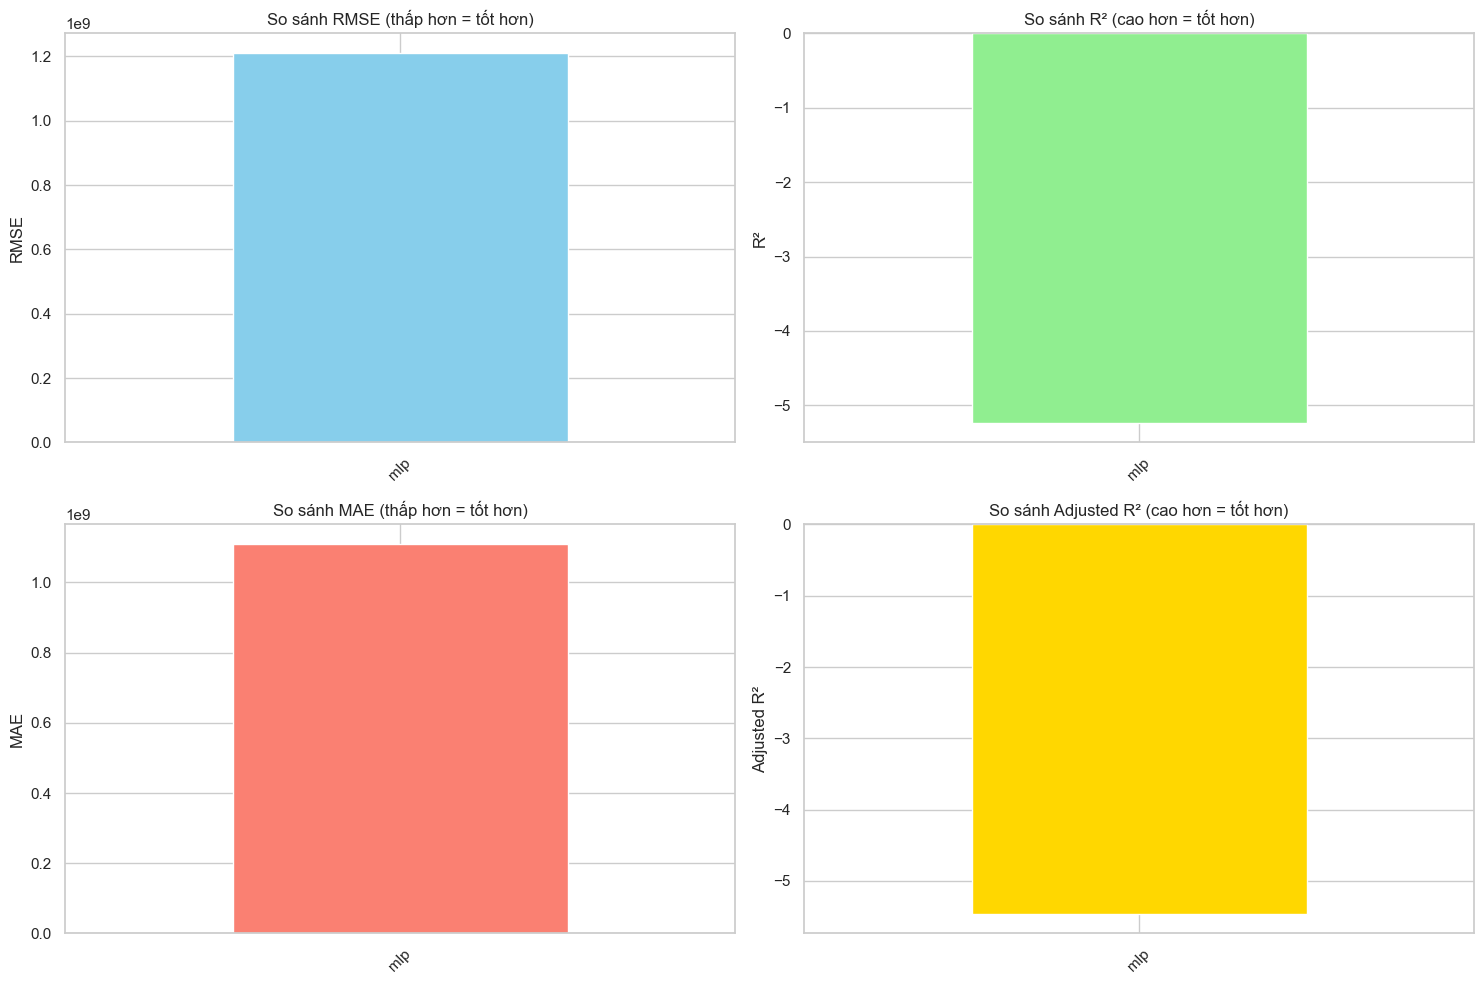

In [25]:
# Đánh giá các mô hình hồi quy
regression_results = {}

if len(regression_models) > 0 and X_test is not None and y_test is not None:
    print("=== ĐÁNH GIÁ MÔ HÌNH HỒI QUY ===\n")
    
    for model_name, model in regression_models.items():
        try:
            print(f"Đang đánh giá mô hình: {model_name}")
            
            # Dự đoán
            y_pred = model.predict(X_test)
            
            # Tính các metric
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            
            # Tính adjusted R²
            n = len(y_test)
            p = X_test.shape[1]
            if n > p + 1:  # Đảm bảo mẫu đủ lớn
                adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
            else:
                adj_r2 = r2  # Fallback nếu mẫu quá nhỏ
            
            # Lưu kết quả
            regression_results[model_name] = {
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R²': r2,
                'Adjusted R²': adj_r2,
                'Predictions': y_pred
            }
            
            print(f"  MAE: {mae:,.0f}")
            print(f"  MSE: {mse:,.0f}")
            print(f"  RMSE: {rmse:,.0f}")
            print(f"  R²: {r2:.4f}")
            print(f"  Adjusted R²: {adj_r2:.4f}")
            print()
            
        except Exception as e:
            print(f"  Lỗi khi đánh giá mô hình {model_name}: {e}")
            print()
    
    # Tạo DataFrame so sánh các mô hình
    if regression_results:
        metrics_df = pd.DataFrame({
            model_name: {
                metric: results[metric] 
                for metric in ['MAE', 'MSE', 'RMSE', 'R²', 'Adjusted R²']
            }
            for model_name, results in regression_results.items()
        }).T
        
        print("BẢNG SO SÁNH CÁC MÔ HÌNH HỒI QUY:")
        display(metrics_df.round(4))
        
        # Xếp hạng các mô hình theo RMSE (thấp hơn là tốt hơn)
        print("\nXẾP HẠNG CÁC MÔ HÌNH THEO RMSE (thấp hơn là tốt hơn):")
        ranking_df = metrics_df.sort_values('RMSE')[['RMSE', 'R²', 'MAE']]
        display(ranking_df.round(4))
        
        # Tìm mô hình tốt nhất
        best_model_name = metrics_df['R²'].idxmax()
        best_r2 = metrics_df.loc[best_model_name, 'R²']
        print(f"\n MÔ HÌNH TỐT NHẤT: {best_model_name} với R² = {best_r2:.4f}")
        
        # Vẽ biểu đồ so sánh
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # RMSE comparison
        metrics_df['RMSE'].sort_values().plot(kind='bar', ax=axes[0,0], color='skyblue')
        axes[0,0].set_title('So sánh RMSE (thấp hơn = tốt hơn)')
        axes[0,0].set_ylabel('RMSE')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # R² comparison
        metrics_df['R²'].sort_values(ascending=False).plot(kind='bar', ax=axes[0,1], color='lightgreen')
        axes[0,1].set_title('So sánh R² (cao hơn = tốt hơn)')
        axes[0,1].set_ylabel('R²')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # MAE comparison
        metrics_df['MAE'].sort_values().plot(kind='bar', ax=axes[1,0], color='salmon')
        axes[1,0].set_title('So sánh MAE (thấp hơn = tốt hơn)')
        axes[1,0].set_ylabel('MAE')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Adjusted R² comparison
        metrics_df['Adjusted R²'].sort_values(ascending=False).plot(kind='bar', ax=axes[1,1], color='gold')
        axes[1,1].set_title('So sánh Adjusted R² (cao hơn = tốt hơn)')
        axes[1,1].set_ylabel('Adjusted R²')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("Không có kết quả đánh giá nào để hiển thị.")
        
elif len(regression_models) == 0:
    print("Không có mô hình hồi quy nào để đánh giá.")
else:
    print("Không có dữ liệu test để đánh giá mô hình hồi quy.")

## Biểu đồ phân tích dư

Biểu đồ phân tích dư (Residual Plot) giúp chúng ta đánh giá độ chính xác của mô hình hồi quy và kiểm tra các giả định:
- Tính tuyến tính
- Phương sai đồng nhất (homoscedasticity)
- Phân phối của các giá trị dư

=== PHÂN TÍCH DƯ CỦA CÁC MÔ HÌNH HỒI QUY ===



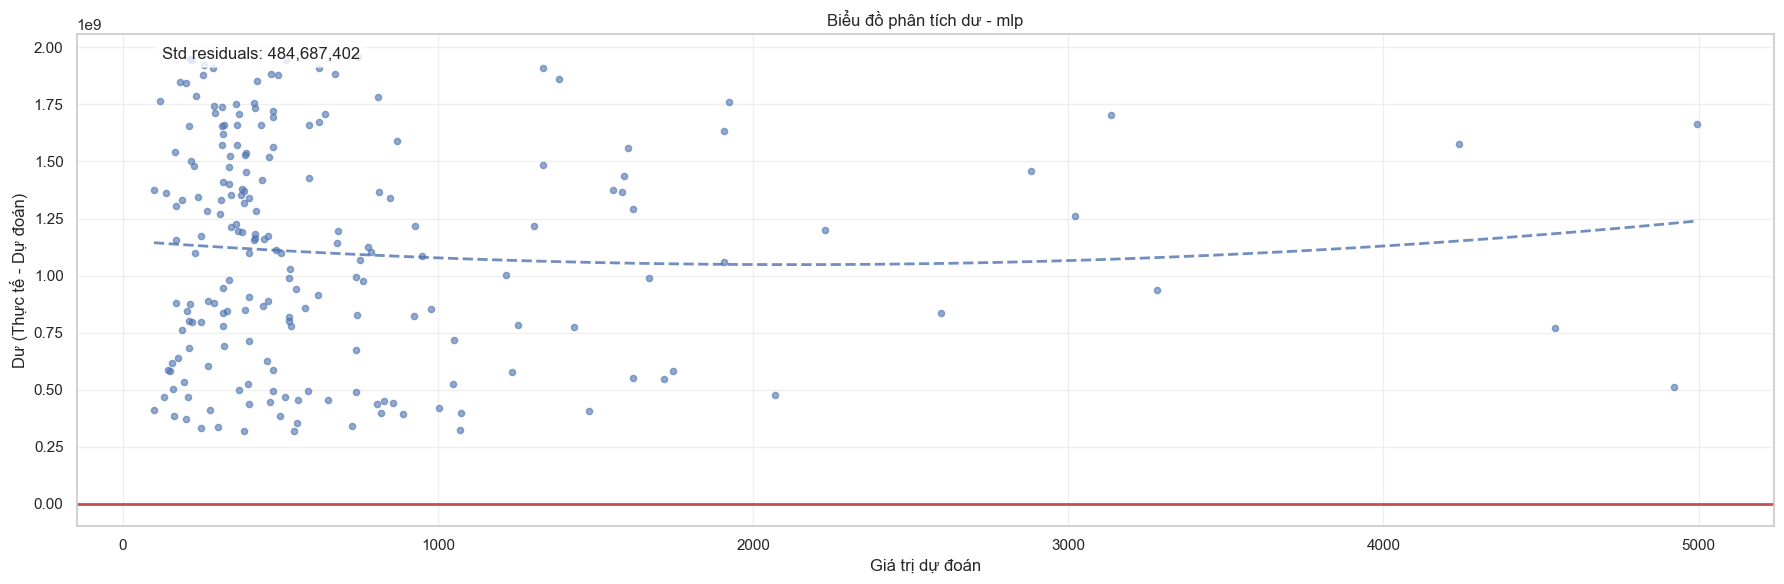

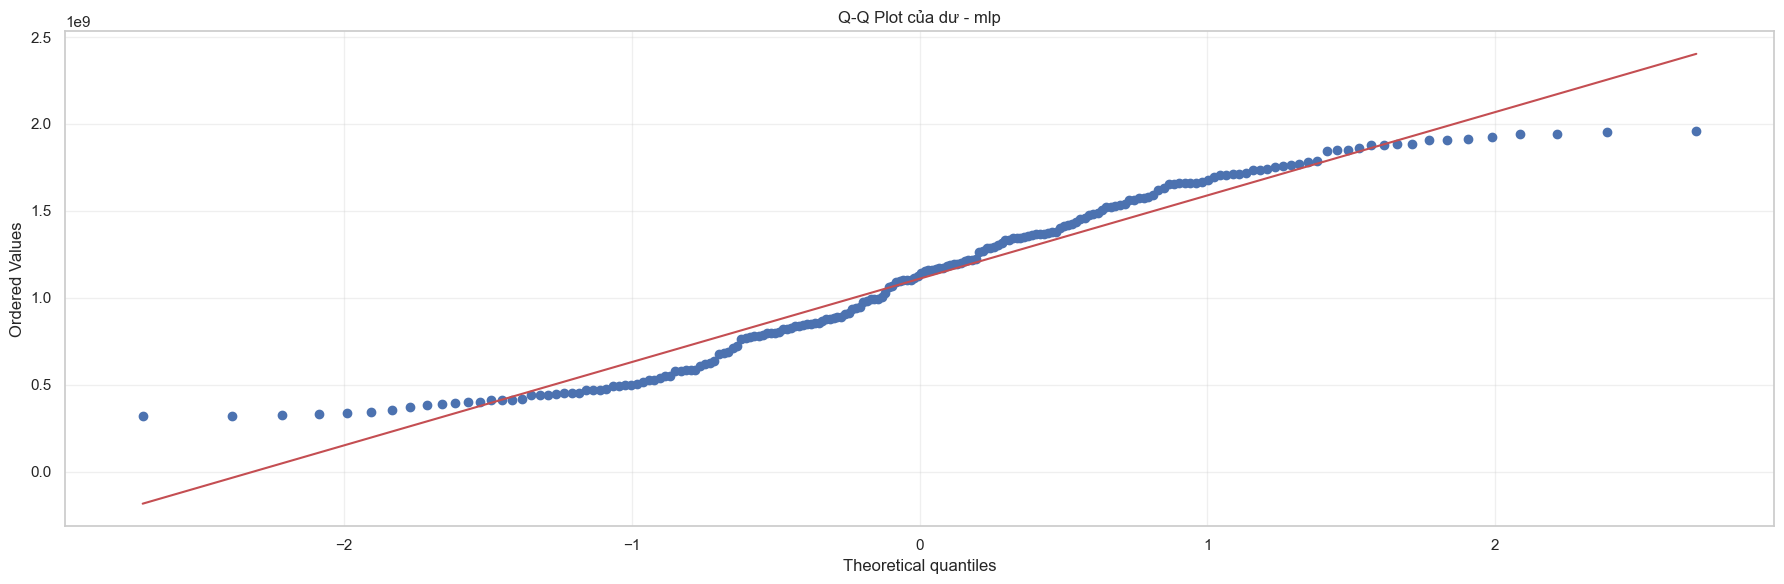

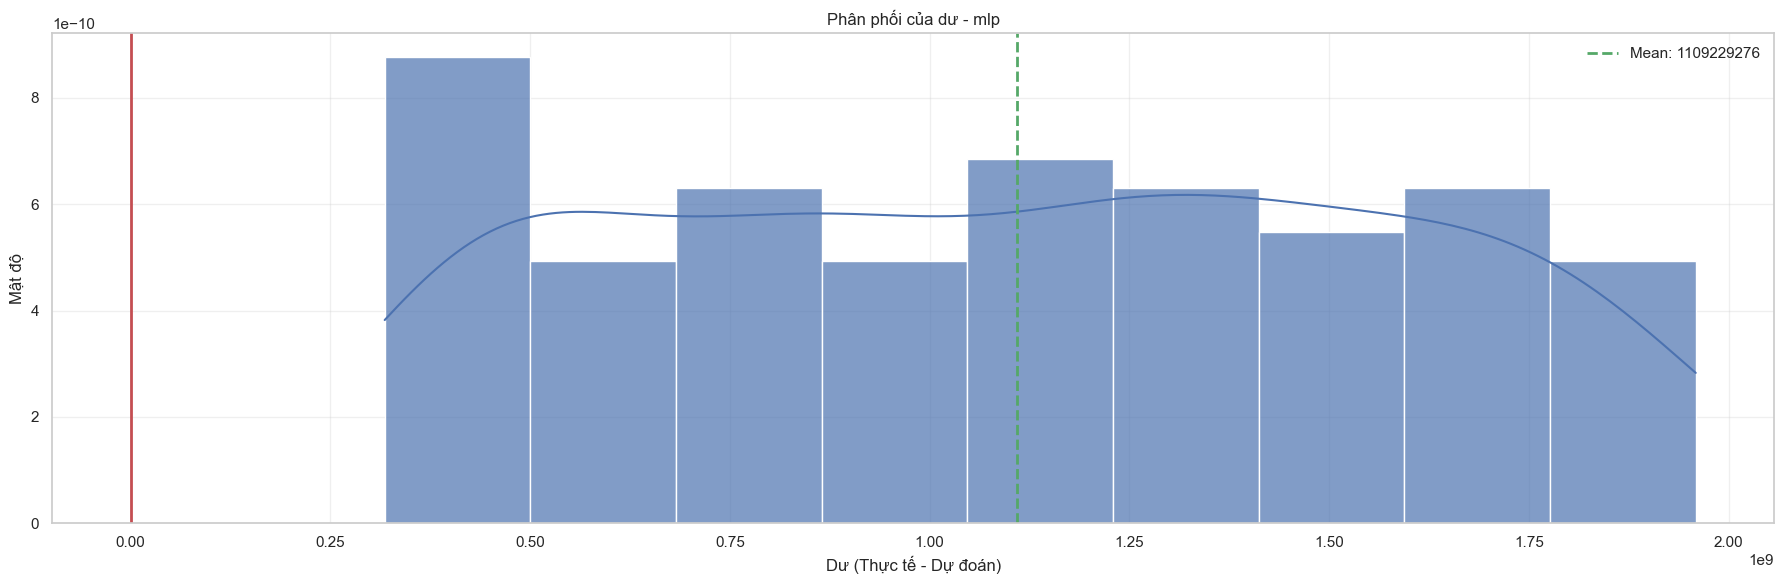

THỐNG KÊ VỀ RESIDUALS:

mlp:
  Mean residuals: 1,109,229,276
  Std residuals: 484,687,402
  Min residuals: 317,999,456
  Max residuals: 1,958,999,254
  Shapiro-Wilk test p-value: 0.0000 (Not normal)


In [13]:
# Tạo biểu đồ phân tích dư cho các mô hình hồi quy
if regression_results and len(regression_results) > 0:
    print("=== PHÂN TÍCH DƯ CỦA CÁC MÔ HÌNH HỒI QUY ===\n")
    
    n_models = len(regression_results)
    n_cols = min(3, n_models)
    n_rows = max(1, (n_models + n_cols - 1) // n_cols)
    
    # 1. Biểu đồ scatter của residuals vs predicted values
    plt.figure(figsize=(18, 6 * n_rows))
    
    for i, (model_name, results) in enumerate(regression_results.items(), 1):
        plt.subplot(n_rows, n_cols, i)
        
        # Tính các giá trị dư (residuals)
        y_pred = results['Predictions']
        residuals = y_test - y_pred
        
        # Vẽ scatter plot các giá trị dư theo giá trị dự đoán
        plt.scatter(y_pred, residuals, alpha=0.6, s=20)
        plt.axhline(y=0, color='r', linestyle='-', linewidth=2)
        
        # Thêm đường trend để kiểm tra pattern
        try:
            z = np.polyfit(y_pred, residuals, 2)
            p = np.poly1d(z)
            xp = np.linspace(min(y_pred), max(y_pred), 100)
            plt.plot(xp, p(xp), 'b--', alpha=0.8, linewidth=2)
        except:
            pass
        
        plt.title(f'Biểu đồ phân tích dư - {model_name}')
        plt.xlabel('Giá trị dự đoán')
        plt.ylabel('Dư (Thực tế - Dự đoán)')
        plt.grid(True, alpha=0.3)
        
        # Thêm thông tin về phân tán của dư
        std_residual = np.std(residuals)
        plt.text(0.05, 0.95, f'Std residuals: {std_residual:,.0f}', 
                transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # 2. Q-Q plot để kiểm tra phân phối chuẩn của các giá trị dư
    plt.figure(figsize=(18, 6 * n_rows))
    
    for i, (model_name, results) in enumerate(regression_results.items(), 1):
        plt.subplot(n_rows, n_cols, i)
        
        # Tính các giá trị dư
        y_pred = results['Predictions']
        residuals = y_test - y_pred
        
        # Vẽ Q-Q plot
        try:
            stats.probplot(residuals, dist="norm", plot=plt)
            plt.title(f'Q-Q Plot của dư - {model_name}')
            plt.grid(True, alpha=0.3)
        except Exception as e:
            plt.text(0.5, 0.5, f"Không thể tạo Q-Q plot\nLỗi: {str(e)}", 
                    ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Histogram phân phối của dư
    plt.figure(figsize=(18, 6 * n_rows))
    
    for i, (model_name, results) in enumerate(regression_results.items(), 1):
        plt.subplot(n_rows, n_cols, i)
        
        # Tính các giá trị dư
        y_pred = results['Predictions']
        residuals = y_test - y_pred
        
        # Vẽ histogram với KDE
        try:
            sns.histplot(residuals, kde=True, stat='density', alpha=0.7)
            plt.axvline(x=0, color='r', linestyle='-', linewidth=2)
            plt.axvline(x=np.mean(residuals), color='g', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals):.0f}')
            
            plt.title(f'Phân phối của dư - {model_name}')
            plt.xlabel('Dư (Thực tế - Dự đoán)')
            plt.ylabel('Mật độ')
            plt.legend()
            plt.grid(True, alpha=0.3)
        except Exception as e:
            plt.text(0.5, 0.5, f"Không thể tạo histogram\nLỗi: {str(e)}", 
                    ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Thống kê về residuals
    print("THỐNG KÊ VỀ RESIDUALS:")
    for model_name, results in regression_results.items():
        y_pred = results['Predictions']
        residuals = y_test - y_pred
        
        print(f"\n{model_name}:")
        print(f"  Mean residuals: {np.mean(residuals):,.0f}")
        print(f"  Std residuals: {np.std(residuals):,.0f}")
        print(f"  Min residuals: {np.min(residuals):,.0f}")
        print(f"  Max residuals: {np.max(residuals):,.0f}")
        
        # Kiểm tra tính chuẩn của residuals
        try:
            from scipy.stats import shapiro
            stat, p_value = shapiro(residuals[:min(5000, len(residuals))])  # Shapiro test chỉ hoạt động với mẫu < 5000
            print(f"  Shapiro-Wilk test p-value: {p_value:.4f} {'(Normal)' if p_value > 0.05 else '(Not normal)'}")
        except:
            print(f"  Không thể thực hiện Shapiro-Wilk test")

else:
    print("Không có dữ liệu residuals để phân tích.")

## Biểu đồ giá trị thực tế so với giá trị dự đoán

So sánh trực quan giữa giá trị thực tế và giá trị dự đoán cho từng mô hình.

=== SO SÁNH GIÁ TRỊ THỰC TẾ VÀ DỰ ĐOÁN ===



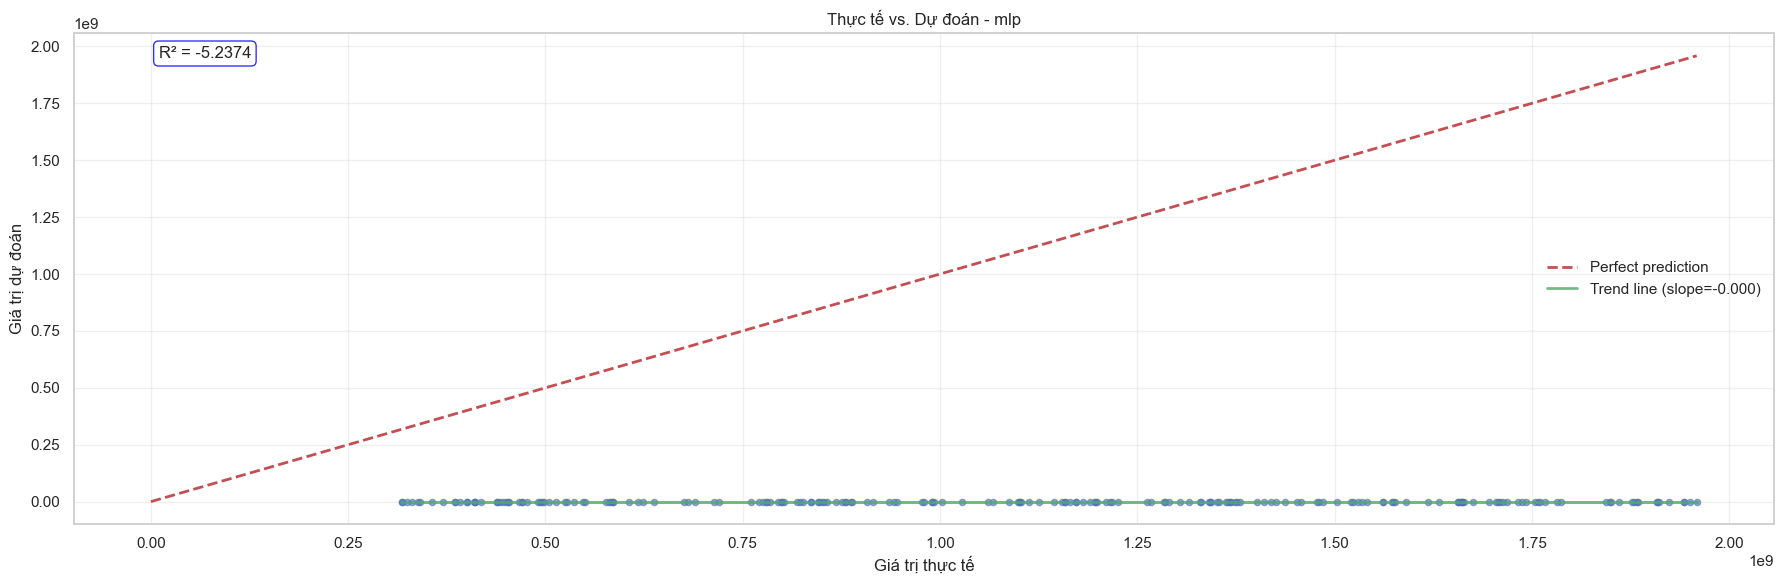

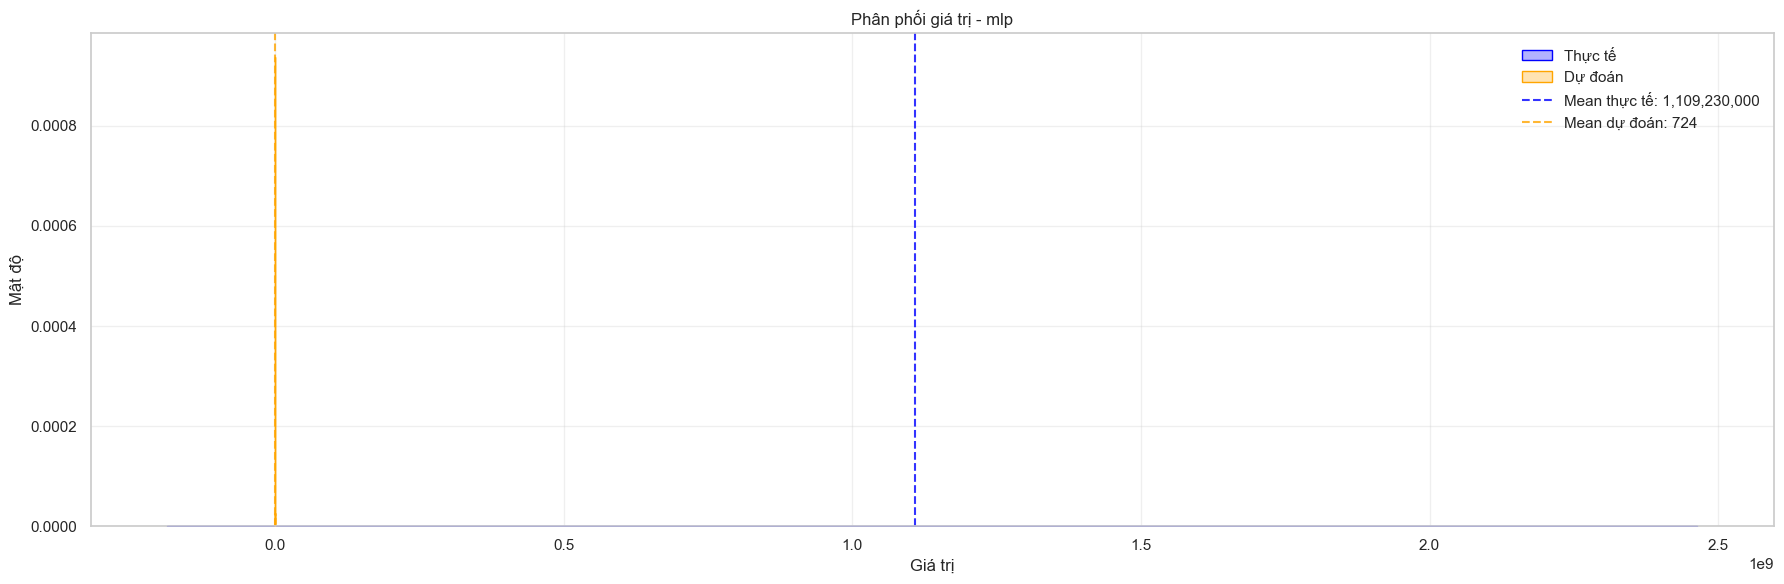

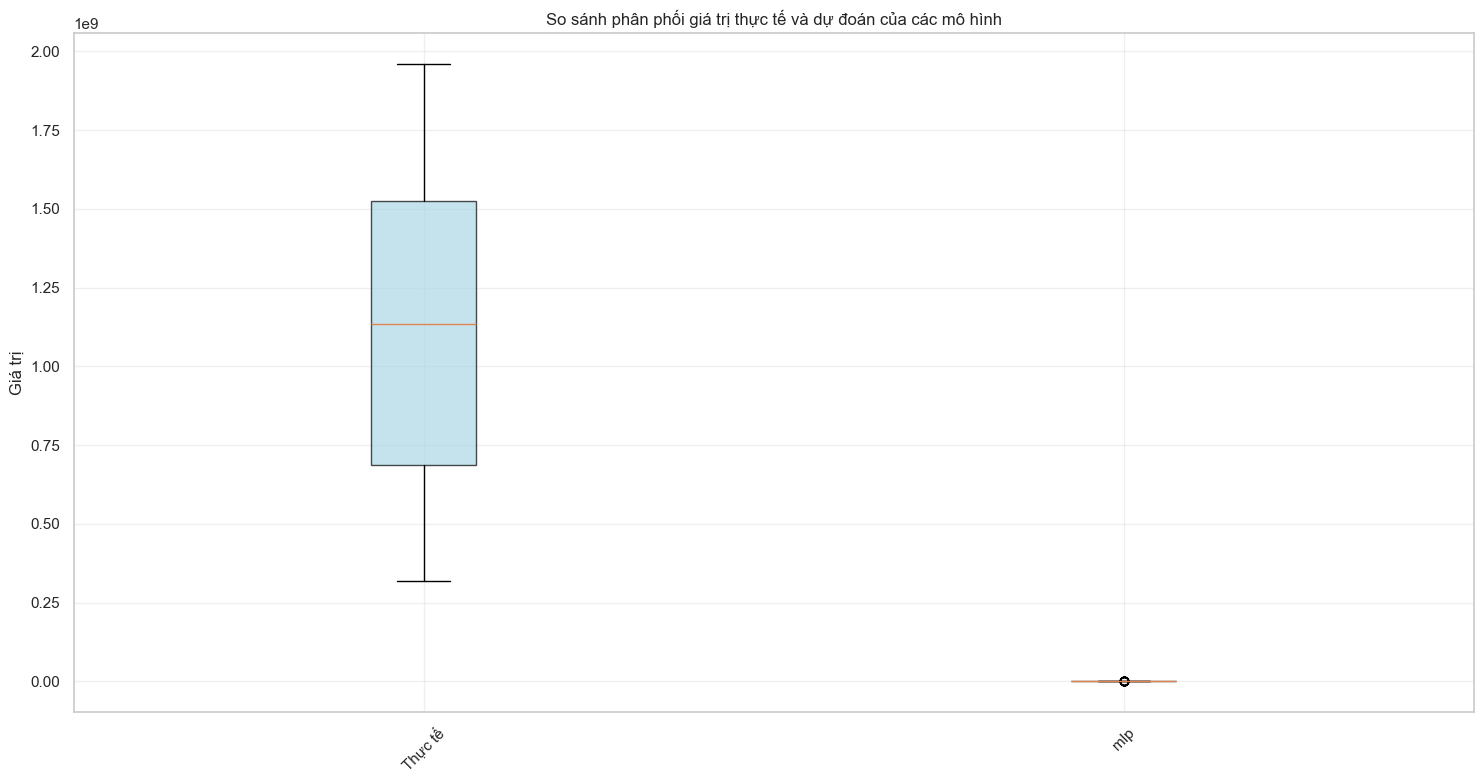

BẢNG THỐNG KÊ SO SÁNH:

Thống kê mô tả:


,Mean,Median,Std,Min,Max
Model,,,,,
Thực tế,"1,109,230,000","1,134,500,000","484,687,391","318,000,000","1,959,000,000"
mlp,724,442,806,98,"4,995"


In [14]:
# Tạo biểu đồ so sánh giá trị thực tế và dự đoán
if regression_results and len(regression_results) > 0:
    print("=== SO SÁNH GIÁ TRỊ THỰC TẾ VÀ DỰ ĐOÁN ===\n")
    
    n_models = len(regression_results)
    n_cols = min(3, n_models)
    n_rows = max(1, (n_models + n_cols - 1) // n_cols)
    
    # 1. Scatter plot: Thực tế vs Dự đoán
    plt.figure(figsize=(18, 6 * n_rows))
    
    for i, (model_name, results) in enumerate(regression_results.items(), 1):
        plt.subplot(n_rows, n_cols, i)
        
        y_pred = results['Predictions']
        
        # Vẽ scatter plot
        plt.scatter(y_test, y_pred, alpha=0.6, s=20)
        
        # Vẽ đường y=x (đường lý tưởng)
        min_val = min(min(y_test), min(y_pred))
        max_val = max(max(y_test), max(y_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
        
        # Tính và vẽ đường hồi quy
        try:
            z = np.polyfit(y_test, y_pred, 1)
            p = np.poly1d(z)
            plt.plot(y_test, p(y_test), 'g-', alpha=0.8, linewidth=2, label=f'Trend line (slope={z[0]:.3f})')
        except:
            pass
        
        plt.title(f'Thực tế vs. Dự đoán - {model_name}')
        plt.xlabel('Giá trị thực tế')
        plt.ylabel('Giá trị dự đoán')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Thêm R² vào biểu đồ
        r2 = results['R²']
        plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="blue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # 2. Phân phối của giá trị thực tế và dự đoán
    plt.figure(figsize=(18, 6 * n_rows))
    
    for i, (model_name, results) in enumerate(regression_results.items(), 1):
        plt.subplot(n_rows, n_cols, i)
        
        y_pred = results['Predictions']
        
        # Vẽ phân phối bằng KDE
        try:
            sns.kdeplot(y_test, label='Thực tế', fill=True, alpha=0.3, color='blue')
            sns.kdeplot(y_pred, label='Dự đoán', fill=True, alpha=0.3, color='orange')
            
            # Thêm đường trung bình
            plt.axvline(np.mean(y_test), color='blue', linestyle='--', alpha=0.8, label=f'Mean thực tế: {np.mean(y_test):,.0f}')
            plt.axvline(np.mean(y_pred), color='orange', linestyle='--', alpha=0.8, label=f'Mean dự đoán: {np.mean(y_pred):,.0f}')
            
            plt.title(f'Phân phối giá trị - {model_name}')
            plt.xlabel('Giá trị')
            plt.ylabel('Mật độ')
            plt.legend()
            plt.grid(True, alpha=0.3)
        except Exception as e:
            plt.text(0.5, 0.5, f"Không thể tạo biểu đồ phân phối\nLỗi: {str(e)}", 
                    ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Boxplot so sánh tổng thể
    plt.figure(figsize=(15, 8))
    
    # Chuẩn bị dữ liệu cho boxplot
    boxplot_data = []
    boxplot_labels = []
    
    # Thêm giá trị thực tế
    boxplot_data.append(y_test.values)
    boxplot_labels.append('Thực tế')
    
    # Thêm giá trị dự đoán từ các mô hình
    for model_name, results in regression_results.items():
        boxplot_data.append(results['Predictions'])
        boxplot_labels.append(f'{model_name}')
    
    # Vẽ boxplot
    box_plot = plt.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True)
    
    # Tô màu cho các box
    colors = ['lightblue'] + ['orange', 'lightgreen', 'pink', 'yellow', 'lightcoral'][:len(regression_results)]
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.title('So sánh phân phối giá trị thực tế và dự đoán của các mô hình')
    plt.ylabel('Giá trị')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Bảng thống kê so sánh
    print("BẢNG THỐNG KÊ SO SÁNH:")
    
    stats_data = []
    
    # Thêm thống kê cho giá trị thực tế
    stats_data.append({
        'Model': 'Thực tế',
        'Mean': np.mean(y_test),
        'Median': np.median(y_test),
        'Std': np.std(y_test),
        'Min': np.min(y_test),
        'Max': np.max(y_test)
    })
    
    # Thêm thống kê cho các mô hình
    for model_name, results in regression_results.items():
        y_pred = results['Predictions']
        stats_data.append({
            'Model': model_name,
            'Mean': np.mean(y_pred),
            'Median': np.median(y_pred),
            'Std': np.std(y_pred),
            'Min': np.min(y_pred),
            'Max': np.max(y_pred)
        })
    
    stats_df = pd.DataFrame(stats_data)
    stats_df = stats_df.set_index('Model')
    
    # Định dạng số
    for col in stats_df.columns:
        stats_df[col] = stats_df[col].apply(lambda x: f"{x:,.0f}")
    
    print("\nThống kê mô tả:")
    display(stats_df)

else:
    print("Không có dữ liệu để tạo biểu đồ so sánh giá trị thực tế và dự đoán.")

## Đánh giá mô hình phân loại

Đối với các mô hình phân loại, chúng ta sẽ đánh giá dựa trên các chỉ số:
- Accuracy
- Precision, Recall, F1-Score
- Ma trận nhầm lẫn (Confusion Matrix)
- ROC Curve và AUC

Số lượng mô hình phân loại hiện có: 1
=== ĐÁNH GIÁ MÔ HÌNH PHÂN LOẠI ===

Thống kê giá xe:
  min: 318,000,000
  max: 1,959,000,000
  25%: 687,750,000
  50%: 1,134,500,000
  75%: 1,524,750,000

Ánh xạ phân khúc giá:
  Cao: 0
  Cao cấp: 1
  Thấp: 2
  Trung bình: 3

Phân phối phân khúc giá:
price
Trung bình    50
Thấp          50
Cao           50
Cao cấp       50
Name: count, dtype: int64

Đang đánh giá mô hình phân loại: naive_bayes
  Accuracy: 0.2700
  Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.38      0.34        50
           1       0.31      0.24      0.27        50
           2       0.21      0.16      0.18        50
           3       0.25      0.30      0.27        50

    accuracy                           0.27       200
   macro avg       0.27      0.27      0.27       200
weighted avg       0.27      0.27      0.27       200


Bảng so sánh các mô hình phân loại:


,Accuracy,F1-score (weighted)
naive_bayes,0.27,0.265123



Xếp hạng các mô hình theo Accuracy (cao hơn là tốt hơn):


,Accuracy,F1-score (weighted)
naive_bayes,0.27,0.265123


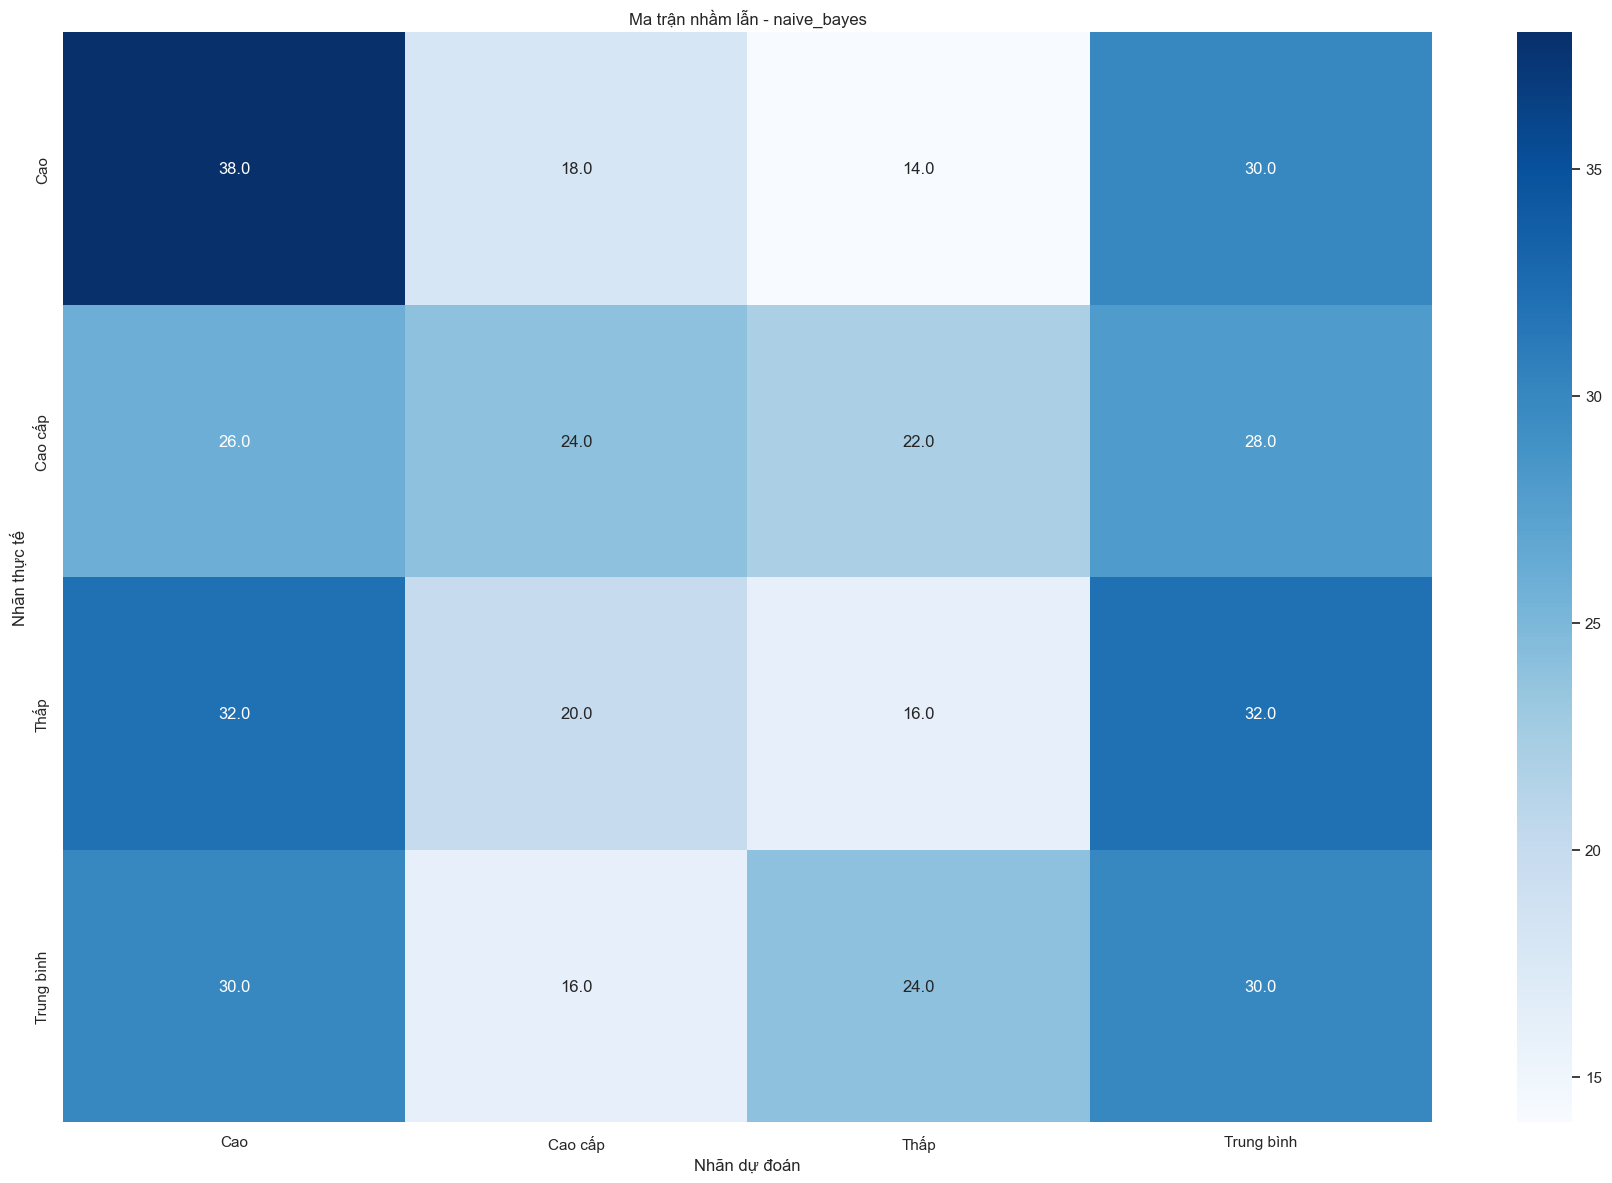

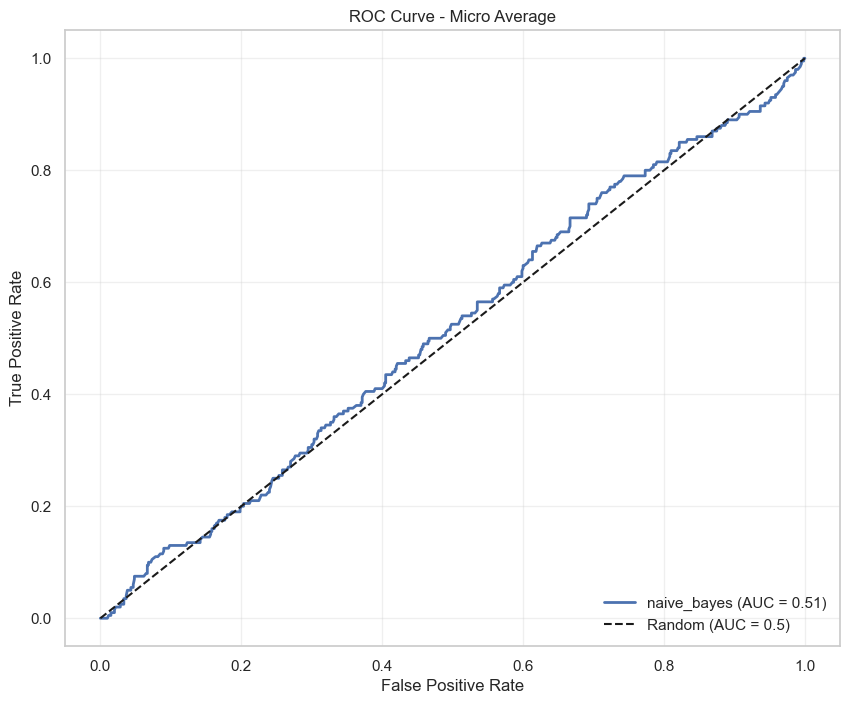

In [21]:
# Chuẩn bị dữ liệu để đánh giá mô hình phân loại
# Giả định rằng chúng ta có thể cần phải tạo phân khúc giá từ cột 'price'

# Kiểm tra xem classification_models đã được định nghĩa chưa
if 'classification_models' not in locals() and 'classification_models' not in globals():
    print("Biến classification_models chưa được định nghĩa. Khởi tạo dictionary rỗng.")
    classification_models = {}

print(f"Số lượng mô hình phân loại hiện có: {len(classification_models)}")

if len(classification_models) > 0 and 'price' in df.columns and X_test is not None:
    print("=== ĐÁNH GIÁ MÔ HÌNH PHÂN LOẠI ===\n")
    
    # Chuẩn bị X_test_clf giống như đã làm với mô hình hồi quy
    X_test_clf = X_test.copy()
    
    # Kiểm tra và xử lý các giá trị NaN trong X_test_clf
    if X_test_clf.isnull().any().any():
        print(f"Phát hiện {X_test_clf.isnull().sum().sum()} giá trị NaN trong dữ liệu test")
        print("Tiến hành xử lý giá trị thiếu...")
        
        # Xử lý giá trị thiếu cho các cột số
        numeric_cols = X_test_clf.select_dtypes(include=['int64', 'float64']).columns
        for col in numeric_cols:
            X_test_clf[col] = X_test_clf[col].fillna(X_test_clf[col].median())
        
        # Xử lý giá trị thiếu cho các cột phân loại
        categorical_cols = X_test_clf.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            X_test_clf[col] = X_test_clf[col].fillna(X_test_clf[col].mode().iloc[0])
        
        print("Đã xử lý xong các giá trị thiếu.")
    
    # Tính các thống kê về giá để tạo ngưỡng phân loại
    price_stats = {
        'min': y_test.min(),
        'max': y_test.max(),
        '25%': y_test.quantile(0.25),
        '50%': y_test.quantile(0.5),
        '75%': y_test.quantile(0.75)
    }
    
    print("Thống kê giá xe:")
    for key, value in price_stats.items():
        print(f"  {key}: {value:,.0f}")
    
    # Hàm để chuyển đổi giá thành phân khúc
    def price_to_category(price):
        # Phân loại dựa trên phân vị
        if price <= price_stats['25%']:
            return 'Thấp'
        elif price <= price_stats['50%']:
            return 'Trung bình'
        elif price <= price_stats['75%']:
            return 'Cao'
        else:
            return 'Cao cấp'
    
    # Tạo y_test cho phân loại
    y_test_category = y_test.apply(price_to_category)
    
    # Tạo ánh xạ phân khúc giá
    unique_categories = sorted(y_test_category.unique())
    category_to_encoding = {cat: i for i, cat in enumerate(unique_categories)}
    encoding_to_category = {i: cat for cat, i in category_to_encoding.items()}
    
    # Lưu ánh xạ phân khúc giá
    price_category_mapping = {
        'category_to_encoding': category_to_encoding,
        'encoding_to_category': encoding_to_category
    }
    
    print("\nÁnh xạ phân khúc giá:")
    for cat, enc in category_to_encoding.items():
        print(f"  {cat}: {enc}")
    
    # Chuyển đổi phân khúc thành mã số
    y_test_clf = y_test_category.map(category_to_encoding)
    
    print("\nPhân phối phân khúc giá:")
    print(y_test_category.value_counts())
    
    # Đánh giá các mô hình phân loại
    classification_results = {}
    
    for model_name, model in classification_models.items():
        try:
            print(f"\nĐang đánh giá mô hình phân loại: {model_name}")
            
            # Dự đoán
            y_pred = model.predict(X_test_clf)
            
            # Dự đoán xác suất (nếu có)
            try:
                y_pred_proba = model.predict_proba(X_test_clf)
                has_proba = True
            except Exception as e:
                print(f"  Không thể dự đoán xác suất: {e}")
                has_proba = False
                y_pred_proba = None
            
            # Tính các metric
            acc = accuracy_score(y_test_clf, y_pred)
            
            # Báo cáo phân loại
            report = classification_report(y_test_clf, y_pred, output_dict=True)
            
            # Ma trận nhầm lẫn
            cm = confusion_matrix(y_test_clf, y_pred)
            
            # Lưu kết quả
            classification_results[model_name] = {
                'Accuracy': acc,
                'Report': report,
                'Confusion Matrix': cm,
                'Predictions': y_pred,
                'Has Proba': has_proba
            }
            
            if has_proba:
                classification_results[model_name]['Probabilities'] = y_pred_proba
            
            print(f"  Accuracy: {acc:.4f}")
            print(f"  Classification Report:")
            print(classification_report(y_test_clf, y_pred))
            
        except Exception as e:
            print(f"  Lỗi khi đánh giá mô hình phân loại {model_name}: {str(e)}")
    
    # Tạo DataFrame so sánh các mô hình phân loại
    if classification_results:
        # Trích xuất độ chính xác và F1-score trung bình
        metrics_df_clf = pd.DataFrame({
            model_name: {
                'Accuracy': results['Accuracy'],
                'F1-score (weighted)': results['Report']['weighted avg']['f1-score'] if 'weighted avg' in results['Report'] else 0
            }
            for model_name, results in classification_results.items()
        }).T
        
        print("\nBảng so sánh các mô hình phân loại:")
        display(metrics_df_clf)
        
        # Xếp hạng các mô hình theo Accuracy
        print("\nXếp hạng các mô hình theo Accuracy (cao hơn là tốt hơn):")
        display(metrics_df_clf.sort_values('Accuracy', ascending=False))
        
        # Vẽ ma trận nhầm lẫn
        plt.figure(figsize=(18, 12))
        
        n_models = len(classification_results)
        n_cols = min(2, n_models)
        n_rows = (n_models + n_cols - 1) // n_cols
        
        for i, (model_name, results) in enumerate(classification_results.items(), 1):
            plt.subplot(n_rows, n_cols, i)
            
            cm = results['Confusion Matrix']
            
            # Chuyển ma trận nhầm lẫn thành phần trăm theo hàng
            cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            
            # Tạo bản đồ nhiệt (heatmap)
            sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
                        xticklabels=list(encoding_to_category.values()),
                        yticklabels=list(encoding_to_category.values()))
            
            plt.title(f'Ma trận nhầm lẫn - {model_name}')
            plt.xlabel('Nhãn dự đoán')
            plt.ylabel('Nhãn thực tế')
        
        plt.tight_layout()
        plt.show()
        
        # Vẽ ROC Curve cho các mô hình có dự đoán xác suất
        models_with_proba = [name for name, results in classification_results.items() if results['Has Proba']]
        
        if models_with_proba:
            plt.figure(figsize=(10, 8))
            
            for model_name in models_with_proba:
                results = classification_results[model_name]
                # Đối với phân loại đa lớp, chúng ta sẽ sử dụng ROC curve one-vs-rest
                n_classes = len(np.unique(y_test_clf))
                
                # Tính ROC curve và AUC cho mỗi lớp
                fpr = {}
                tpr = {}
                roc_auc = {}
                
                try:
                    for i in range(n_classes):
                        fpr[i], tpr[i], _ = roc_curve(
                            (y_test_clf == i).astype(int),
                            results['Probabilities'][:, i]
                        )
                        roc_auc[i] = auc(fpr[i], tpr[i])
                    
                    # Tính micro-average ROC curve và AUC
                    y_test_bin = label_binarize(y_test_clf, classes=range(n_classes))
                    fpr["micro"], tpr["micro"], _ = roc_curve(
                        y_test_bin.ravel(),
                        results['Probabilities'].ravel()
                    )
                    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
                    
                    # Vẽ micro-average ROC curve
                    plt.plot(fpr["micro"], tpr["micro"],
                             label=f'{model_name} (AUC = {roc_auc["micro"]:.2f})',
                             linewidth=2)
                except Exception as e:
                    print(f"  Không thể vẽ ROC curve cho {model_name}: {str(e)}")
            
            # Vẽ đường chéo
            plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
            
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve - Micro Average')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            
            plt.show()
else:
    print("Không thể đánh giá mô hình phân loại vì thiếu dữ liệu giá hoặc không có mô hình phân loại nào được nạp.")

## Phân tích độ nhạy của mô hình

Phân tích độ nhạy (Sensitivity Analysis) giúp chúng ta hiểu được ảnh hưởng của từng đặc trưng đối với dự đoán của mô hình.


=== PHÂN TÍCH ĐỘ NHẠY CỦA MÔ HÌNH ===

1. Phân tích Permutation Importance
   Permutation importance đo lường tầm quan trọng của một đặc trưng
   bằng cách đánh giá mức độ giảm hiệu suất khi đặc trưng đó bị xáo trộn.
   Đang tính permutation importance cho mô hình mlp...


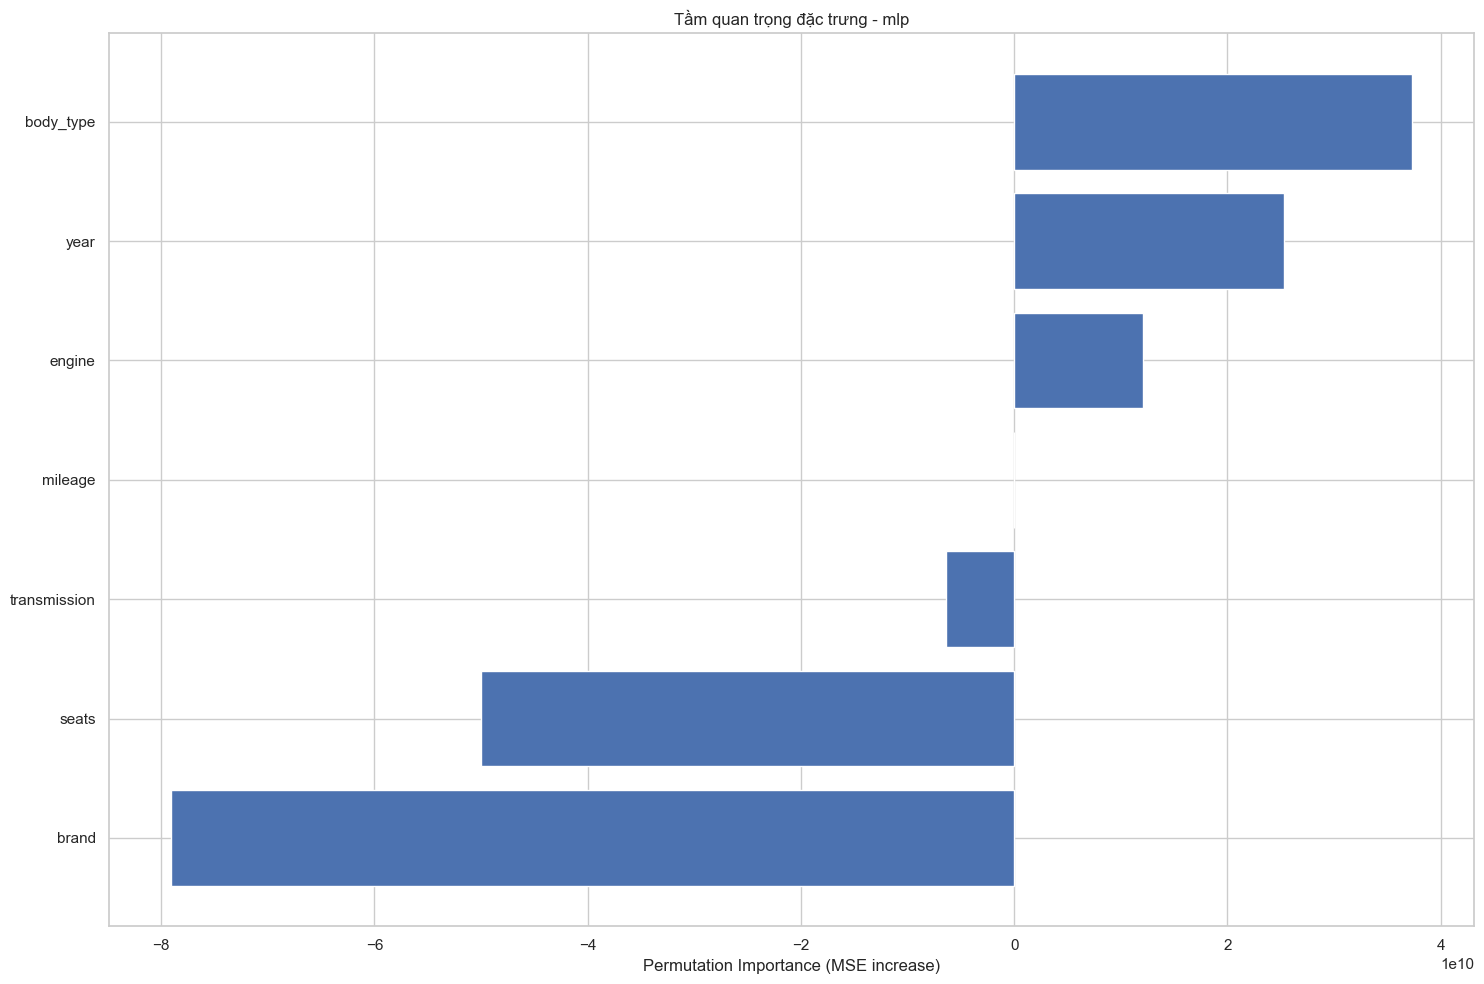


2. Phân tích hệ số và tầm quan trọng đặc trưng theo từng mô hình
   Hiển thị các hệ số hoặc tầm quan trọng đặc trưng nếu mô hình hỗ trợ.

   Phân tích mô hình: mlp
   - Mô hình mlp là pipeline
   - Pipeline không có thuộc tính hỗ trợ phân tích độ nhạy trực tiếp
   - Sẽ sử dụng phương pháp thay thế để đánh giá...
   Không thể trích xuất hệ số hoặc tầm quan trọng đặc trưng trực tiếp từ mô hình mlp
   Sử dụng phương pháp phân tích độ nhạy thay thế...
   Không thể thực hiện phân tích thay thế: unsupported operand type(s) for /: 'str' and 'int'

Phân tích độ nhạy hoàn tất.


In [22]:
# Phân tích độ nhạy của mô hình hồi quy
print("\n=== PHÂN TÍCH ĐỘ NHẠY CỦA MÔ HÌNH ===")

# Kiểm tra các điều kiện trước khi bắt đầu phân tích
if y_test is None or X_test is None:
    print("Không thể phân tích độ nhạy: Thiếu dữ liệu kiểm thử (X_test hoặc y_test).")
elif not regression_models:
    print("Không thể phân tích độ nhạy: Không có mô hình hồi quy nào được nạp.")
else:
    # Thực hiện phân tích độ nhạy bằng permutation importance
    print("\n1. Phân tích Permutation Importance")
    print("   Permutation importance đo lường tầm quan trọng của một đặc trưng")
    print("   bằng cách đánh giá mức độ giảm hiệu suất khi đặc trưng đó bị xáo trộn.")
    
    try:
        from sklearn.inspection import permutation_importance
        
        plt.figure(figsize=(15, 10))
        
        # Xác định số lượng mô hình và sắp xếp subplot
        n_models = len(regression_models)
        n_cols = min(2, n_models)
        n_rows = (n_models + n_cols - 1) // n_cols
        
        # Đảm bảo X_test là DataFrame để có tên cột
        if not hasattr(X_test, 'columns'):
            print("   Chuyển đổi X_test thành DataFrame để dễ hiển thị tên đặc trưng...")
            X_test_df = pd.DataFrame(X_test, columns=[f"feature_{i}" for i in range(X_test.shape[1])])
        else:
            X_test_df = X_test
        
        feature_names = X_test_df.columns.tolist()
        
        for i, (model_name, model) in enumerate(regression_models.items(), 1):
            plt.subplot(n_rows, n_cols, i)
            
            try:
                # Bỏ qua các file không phải là mô hình
                if model_name == "feature_info" or not hasattr(model, 'predict'):
                    plt.text(0.5, 0.5, f"{model_name} không phải là mô hình hồi quy.",
                             ha='center', va='center', fontsize=12)
                    continue
                    
                # Tính permutation importance với xử lý lỗi
                print(f"   Đang tính permutation importance cho mô hình {model_name}...")
                try:
                    r = permutation_importance(
                        model, X_test_df, y_test, 
                        n_repeats=5, 
                        random_state=42, 
                        n_jobs=-1,
                        scoring='neg_mean_squared_error'
                    )
                    
                    # Sắp xếp đặc trưng theo tầm quan trọng
                    importance = r.importances_mean
                    indices = np.argsort(importance)
                    
                    # Vẽ biểu đồ tầm quan trọng
                    plt.barh(range(len(indices)), importance[indices])
                    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
                    plt.xlabel('Permutation Importance (MSE increase)')
                    plt.title(f'Tầm quan trọng đặc trưng - {model_name}')
                    plt.tight_layout()
                except Exception as inner_e:
                    plt.text(0.5, 0.5, f"Không thể tính permutation importance\nLỗi: {str(inner_e)}",
                             ha='center', va='center', fontsize=12)
            except Exception as e:
                plt.text(0.5, 0.5, f"Lỗi khi phân tích {model_name}\nLỗi: {str(e)}",
                         ha='center', va='center', fontsize=12)
                print(f"   Lỗi khi phân tích {model_name}: {str(e)}")
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Lỗi khi thực hiện permutation importance: {str(e)}")
    
    print("\n2. Phân tích hệ số và tầm quan trọng đặc trưng theo từng mô hình")
    print("   Hiển thị các hệ số hoặc tầm quan trọng đặc trưng nếu mô hình hỗ trợ.")
    
    for model_name, model in regression_models.items():
        try:
            # Bỏ qua các mục không phải là mô hình
            if model_name == "feature_info" or not hasattr(model, 'predict'):
                print(f"   Bỏ qua {model_name} (không phải là mô hình hồi quy)")
                continue
            
            print(f"\n   Phân tích mô hình: {model_name}")
            
            # Xác định loại mô hình và hiển thị thông tin phù hợp
            model_info = {}
            
            # Trường hợp 1: Mô hình có hệ số trực tiếp
            if hasattr(model, 'coef_'):
                print(f"   - Mô hình {model_name} có hệ số (linear model)")
                coefs = model.coef_
                intercept = model.intercept_
                model_info['type'] = 'linear'
                model_info['coef'] = coefs
                model_info['intercept'] = intercept
                
            # Trường hợp 2: Mô hình dựa trên cây có feature_importances_
            elif hasattr(model, 'feature_importances_'):
                print(f"   - Mô hình {model_name} có feature importances (tree-based model)")
                importances = model.feature_importances_
                model_info['type'] = 'tree'
                model_info['importances'] = importances
                
            # Trường hợp 3: Mô hình pipeline
            elif hasattr(model, 'steps'):
                print(f"   - Mô hình {model_name} là pipeline")
                final_step = model.steps[-1][1]
                
                if hasattr(final_step, 'coef_'):
                    print(f"   - Bước cuối của pipeline có hệ số (linear model)")
                    coefs = final_step.coef_
                    intercept = final_step.intercept_
                    model_info['type'] = 'pipeline_linear'
                    model_info['coef'] = coefs
                    model_info['intercept'] = intercept
                    
                elif hasattr(final_step, 'feature_importances_'):
                    print(f"   - Bước cuối của pipeline có feature importances (tree-based model)")
                    importances = final_step.feature_importances_
                    model_info['type'] = 'pipeline_tree'
                    model_info['importances'] = importances
                else:
                    print(f"   - Pipeline không có thuộc tính hỗ trợ phân tích độ nhạy trực tiếp")
                    print(f"   - Sẽ sử dụng phương pháp thay thế để đánh giá...")
                    model_info['type'] = 'other'
            else:
                print(f"   - Mô hình {model_name} không có thuộc tính hỗ trợ phân tích độ nhạy trực tiếp")
                print(f"   - Sẽ sử dụng phương pháp thay thế để đánh giá...")
                model_info['type'] = 'other'
            
            # Hiển thị thông tin phù hợp với loại mô hình
            if model_info['type'] in ['linear', 'pipeline_linear']:
                coefs = model_info['coef']
                intercept = model_info['intercept']
                
                # Tạo danh sách tên đặc trưng phù hợp với số lượng hệ số
                if hasattr(X_test, 'columns') and len(X_test.columns) == len(coefs):
                    feat_names = X_test.columns
                else:
                    feat_names = [f"feature_{i}" for i in range(len(coefs))]
                
                # Tạo DataFrame để hiển thị hệ số
                coef_df = pd.DataFrame({
                    'Feature': feat_names,
                    'Coefficient': coefs
                })
                coef_df = coef_df.sort_values('Coefficient', ascending=False)
                
                print(f"   Hệ số của mô hình {model_name}:")
                print(f"   Intercept: {intercept}")
                display(coef_df)
                
                # Vẽ biểu đồ hệ số
                plt.figure(figsize=(12, 8))
                top_features = coef_df.head(min(20, len(coef_df)))
                plt.barh(top_features['Feature'], top_features['Coefficient'])
                plt.xlabel('Hệ số')
                plt.title(f'Hệ số của mô hình {model_name} (top {len(top_features)})')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
            elif model_info['type'] in ['tree', 'pipeline_tree']:
                importances = model_info['importances']
                
                # Tạo danh sách tên đặc trưng phù hợp với số lượng feature_importances
                if hasattr(X_test, 'columns') and len(X_test.columns) == len(importances):
                    feat_names = X_test.columns
                else:
                    feat_names = [f"feature_{i}" for i in range(len(importances))]
                
                # Tạo DataFrame để hiển thị feature importances
                imp_df = pd.DataFrame({
                    'Feature': feat_names,
                    'Importance': importances
                })
                imp_df = imp_df.sort_values('Importance', ascending=False)
                
                print(f"   Tầm quan trọng của đặc trưng trong mô hình {model_name}:")
                display(imp_df)
                
                # Vẽ biểu đồ feature importances
                plt.figure(figsize=(12, 8))
                top_features = imp_df.head(min(20, len(imp_df)))
                plt.barh(top_features['Feature'], top_features['Importance'])
                plt.xlabel('Feature Importance')
                plt.title(f'Tầm quan trọng của đặc trưng - {model_name} (top {len(top_features)})')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
            else:
                # Cho mô hình không có thuộc tính hệ số hoặc feature importances
                # Sử dụng tương quan giữa đặc trưng và dự đoán
                print(f"   Không thể trích xuất hệ số hoặc tầm quan trọng đặc trưng trực tiếp từ mô hình {model_name}")
                print(f"   Sử dụng phương pháp phân tích độ nhạy thay thế...")
                
                try:
                    # Tính độ nhạy bằng cách phân tích tương quan giữa đặc trưng và dự đoán
                    y_pred = model.predict(X_test)
                    
                    # Tạo DataFrame với đặc trưng và dự đoán
                    sensitivity_df = X_test_df.copy()
                    sensitivity_df['prediction'] = y_pred
                    
                    # Tính tương quan
                    correlations = []
                    for col in X_test_df.columns:
                        corr = np.corrcoef(sensitivity_df[col], sensitivity_df['prediction'])[0, 1]
                        correlations.append((col, abs(corr)))
                    
                    # Sắp xếp theo độ lớn của tương quan
                    correlations.sort(key=lambda x: x[1], reverse=True)
                    
                    # Tạo DataFrame
                    corr_df = pd.DataFrame(correlations, columns=['Feature', 'Absolute Correlation'])
                    
                    print(f"   Tương quan giữa đặc trưng và dự đoán của mô hình {model_name}:")
                    display(corr_df)
                    
                    # Vẽ biểu đồ tương quan
                    plt.figure(figsize=(12, 8))
                    plt.barh(corr_df['Feature'], corr_df['Absolute Correlation'])
                    plt.xlabel('Tương quan tuyệt đối với dự đoán')
                    plt.title(f'Mức độ ảnh hưởng của đặc trưng - {model_name}')
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"   Không thể thực hiện phân tích thay thế: {str(e)}")
                    
        except Exception as e:
            print(f"   Lỗi khi phân tích mô hình {model_name}: {str(e)}")
            
    print("\nPhân tích độ nhạy hoàn tất.")

## Phân tích đường cong học tập

Đường cong học tập (Learning Curve) giúp chúng ta đánh giá hiệu suất của mô hình theo kích thước tập huấn luyện và phát hiện vấn đề underfitting/overfitting.


=== PHÂN TÍCH ĐƯỜNG CONG HỌC TẬP ===
Sử dụng 1 mô hình hợp lệ để phân tích đường cong học tập.
Đang tính đường cong học tập cho mô hình mlp...
  Mô hình mlp có dấu hiệu overfitting


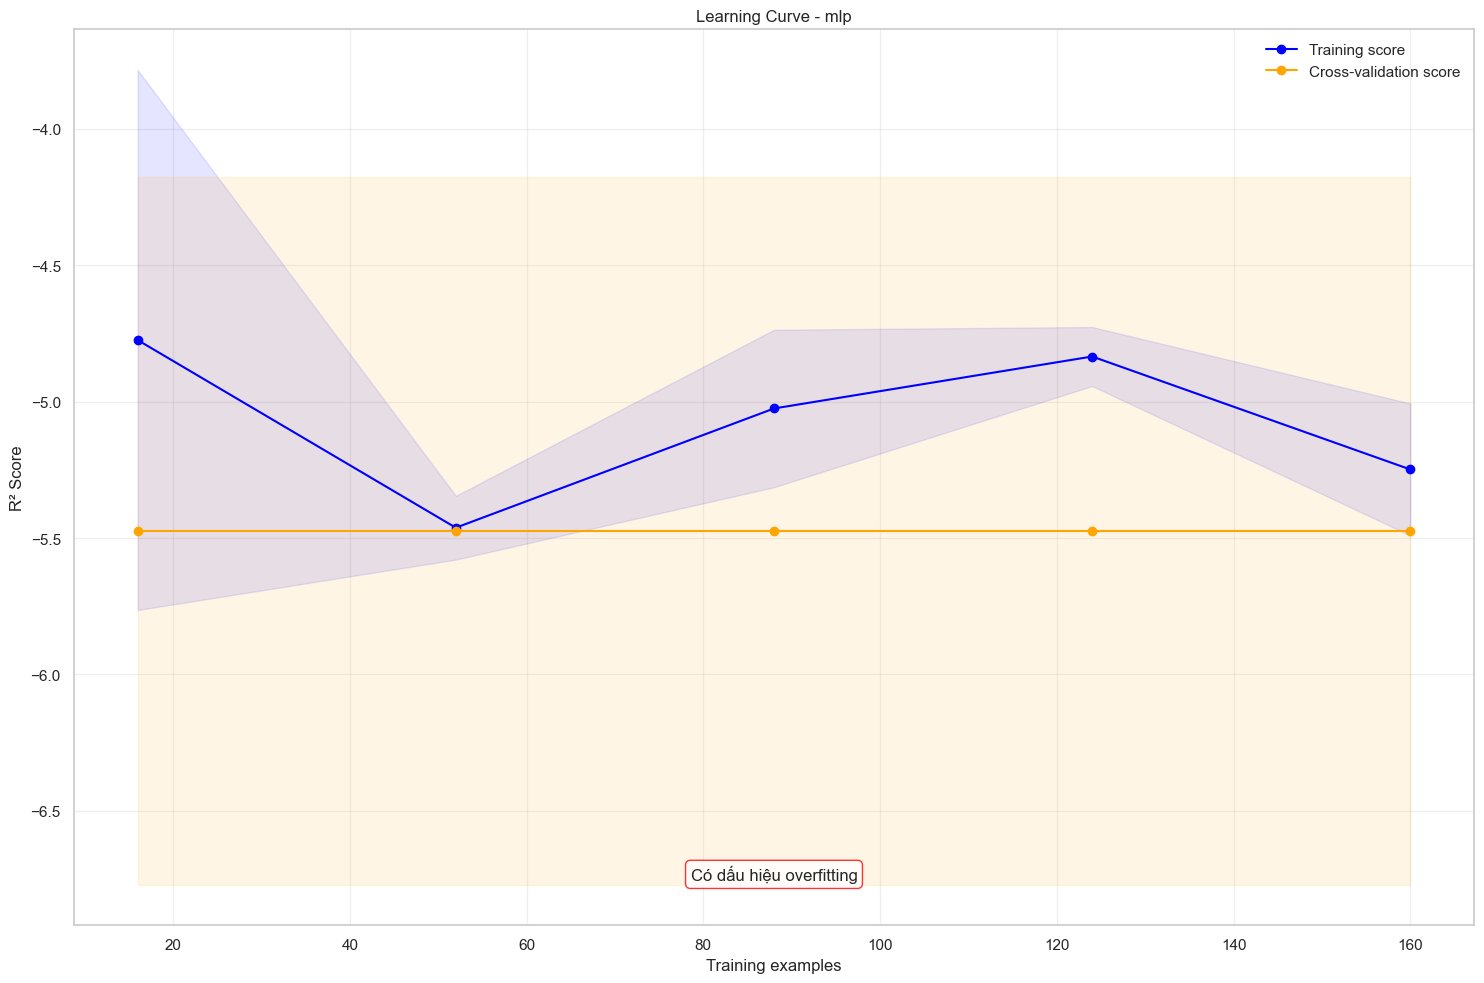

In [23]:
# Phân tích đường cong học tập cho các mô hình hồi quy
print("\n=== PHÂN TÍCH ĐƯỜNG CONG HỌC TẬP ===")

# Phân tích đường cong học tập
if X_test is None or y_test is None:
    print("Không thể phân tích đường cong học tập: Thiếu dữ liệu kiểm thử (X_test hoặc y_test).")
elif not regression_models:
    print("Không thể phân tích đường cong học tập: Không có mô hình hồi quy nào được nạp.")
else:
    try:
        from sklearn.model_selection import learning_curve
        
        # Lọc các mô hình thực sự để tránh các item không phải là mô hình
        valid_models = {}
        for name, model in regression_models.items():
            if name != "feature_info" and hasattr(model, 'predict'):
                valid_models[name] = model
        
        if not valid_models:
            print("Không tìm thấy mô hình hợp lệ để phân tích đường cong học tập.")
        else:
            print(f"Sử dụng {len(valid_models)} mô hình hợp lệ để phân tích đường cong học tập.")
            
            # Vẽ đường cong học tập cho các mô hình
            plt.figure(figsize=(15, 10))
            
            # Xác định số lượng mô hình và sắp xếp subplot
            n_models = min(3, len(valid_models))  # Chỉ vẽ tối đa 3 mô hình để tiết kiệm thời gian
            n_cols = min(2, n_models)
            n_rows = (n_models + n_cols - 1) // n_cols
            
            # Đảm bảo có đủ dữ liệu để cross-validation
            min_cv = min(5, len(X_test) // 3)  # Tối đa 5 fold, tối thiểu 3 mẫu mỗi fold
            if min_cv < 2:
                print(f"Cảnh báo: Dữ liệu kiểm thử quá nhỏ ({len(X_test)} mẫu) cho cross-validation chuẩn.")
                print("Sử dụng 2-fold CV để tiếp tục phân tích.")
                min_cv = 2
            
            for i, (model_name, model) in enumerate(list(valid_models.items())[:n_models], 1):
                plt.subplot(n_rows, n_cols, i)
                
                try:
                    # Định nghĩa các kích thước tập huấn luyện
                    train_sizes = np.linspace(0.1, 1.0, min(5, len(X_test) // min_cv))
                    
                    print(f"Đang tính đường cong học tập cho mô hình {model_name}...")
                    
                    # Tính learning curve với bắt lỗi và thông báo tiến trình
                    train_sizes, train_scores, test_scores = learning_curve(
                        model, X_test, y_test, 
                        train_sizes=train_sizes, 
                        cv=min_cv, 
                        scoring='r2',
                        n_jobs=-1, 
                        random_state=42
                    )
                    
                    # Tính giá trị trung bình và độ lệch chuẩn
                    train_mean = np.mean(train_scores, axis=1)
                    train_std = np.std(train_scores, axis=1)
                    test_mean = np.mean(test_scores, axis=1)
                    test_std = np.std(test_scores, axis=1)
                    
                    # Vẽ biểu đồ learning curve
                    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                                    alpha=0.1, color='blue')
                    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, 
                                    alpha=0.1, color='orange')
                    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
                    plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Cross-validation score')
                    
                    plt.title(f'Learning Curve - {model_name}')
                    plt.xlabel('Training examples')
                    plt.ylabel('R² Score')
                    plt.legend(loc='best')
                    plt.grid(True, alpha=0.3)
                    
                    # Thêm kết luận về overfitting/underfitting
                    if train_mean[-1] - test_mean[-1] > 0.2:
                        plt.text(0.5, 0.05, "Có dấu hiệu overfitting", 
                                ha='center', transform=plt.gca().transAxes,
                                bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="white", alpha=0.8))
                        print(f"  Mô hình {model_name} có dấu hiệu overfitting")
                    elif test_mean[-1] < 0.5:
                        plt.text(0.5, 0.05, "Có dấu hiệu underfitting", 
                                ha='center', transform=plt.gca().transAxes,
                                bbox=dict(boxstyle="round,pad=0.3", edgecolor="orange", facecolor="white", alpha=0.8))
                        print(f"  Mô hình {model_name} có dấu hiệu underfitting")
                    else:
                        print(f"  Mô hình {model_name} có vẻ phù hợp (không rõ dấu hiệu overfitting/underfitting)")
                    
                except Exception as e:
                    error_msg = str(e)
                    plt.text(0.5, 0.5, f"Không thể tạo learning curve cho {model_name}\nLỗi: {error_msg}",
                            ha='center', va='center', fontsize=12)
                    print(f"  Lỗi khi tính đường cong học tập cho {model_name}: {error_msg}")
            
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Lỗi khi phân tích đường cong học tập: {str(e)}")
        print("Bỏ qua phân tích đường cong học tập.")

## Kết luận và phân tích tổng hợp

Tổng hợp kết quả đánh giá và đưa ra các kết luận về hiệu suất của các mô hình.

In [24]:
# Tổng hợp kết quả và đưa ra kết luận

# So sánh tổng thể các mô hình hồi quy
if 'regression_results' in locals() and regression_results:
    # Tạo metrics_df từ regression_results nếu chưa có
    if 'metrics_df' not in locals() or metrics_df.empty:
        metrics_df = pd.DataFrame({
            model_name: {
                metric: results[metric] 
                for metric in ['MAE', 'MSE', 'RMSE', 'R²', 'Adjusted R²'] if metric in results
            }
            for model_name, results in regression_results.items()
        }).T
        
    print("=== TỔNG HỢP ĐÁNH GIÁ MÔ HÌNH HỒI QUY ===")
    
    # Kiểm tra metrics_df có dữ liệu không
    if not metrics_df.empty and len(metrics_df) > 0:
        # Tìm mô hình tốt nhất theo từng metric
        best_models = {}
        
        # Kiểm tra từng metric có tồn tại không trước khi tìm min/max
        if 'MAE' in metrics_df.columns:
            best_models['Lowest MAE'] = metrics_df['MAE'].idxmin()
        if 'MSE' in metrics_df.columns:
            best_models['Lowest MSE'] = metrics_df['MSE'].idxmin()
        if 'RMSE' in metrics_df.columns:
            best_models['Lowest RMSE'] = metrics_df['RMSE'].idxmin()
        if 'R²' in metrics_df.columns:
            best_models['Highest R²'] = metrics_df['R²'].idxmax()
        if 'Adjusted R²' in metrics_df.columns:
            best_models['Highest Adjusted R²'] = metrics_df['Adjusted R²'].idxmax()
        
        # In ra mô hình tốt nhất theo từng tiêu chí
        print("\nMô hình tốt nhất theo từng tiêu chí:")
        for metric, model in best_models.items():
            print(f"- {metric}: {model}")
        
        # Tìm mô hình tốt nhất tổng thể nếu có đủ metrics
        if len(metrics_df.columns) >= 3:  # Đảm bảo có ít nhất 3 metrics để so sánh
            # Chuẩn hóa các metric về cùng thang đo (0-1) và đổi dấu để các giá trị cao hơn = tốt hơn
            normalized_df = metrics_df.copy()
            
            # Đối với MAE, MSE, RMSE: thấp hơn = tốt hơn → đổi dấu sau khi chuẩn hóa
            for metric in ['MAE', 'MSE', 'RMSE']:
                if metric in normalized_df.columns:
                    max_val = normalized_df[metric].max()
                    min_val = normalized_df[metric].min()
                    if max_val > min_val:  # Tránh chia cho 0
                        normalized_df[metric] = 1 - (normalized_df[metric] - min_val) / (max_val - min_val)
            
            # Đối với R², Adjusted R²: cao hơn = tốt hơn → chuẩn hóa trực tiếp
            for metric in ['R²', 'Adjusted R²']:
                if metric in normalized_df.columns:
                    max_val = normalized_df[metric].max()
                    min_val = normalized_df[metric].min()
                    if max_val > min_val:  # Tránh chia cho 0
                        normalized_df[metric] = (normalized_df[metric] - min_val) / (max_val - min_val)
            
            # Tính điểm tổng hợp (đơn giản là trung bình của các metric đã chuẩn hóa)
            normalized_df['Overall Score'] = normalized_df.mean(axis=1)
            
            # Xếp hạng các mô hình theo điểm tổng hợp
            ranked_models = normalized_df.sort_values('Overall Score', ascending=False)
            
            print("\nXếp hạng các mô hình hồi quy theo điểm tổng hợp:")
            for i, (model, score) in enumerate(zip(ranked_models.index, ranked_models['Overall Score']), 1):
                print(f"{i}. {model}: {score:.4f}")
            
            # Đề xuất mô hình tốt nhất
            best_model = ranked_models.index[0]
            print(f"\n➤ Đề xuất: Mô hình {best_model} có hiệu suất tốt nhất tổng thể.")
            print(f"   Các chỉ số của mô hình này:")
            for metric in metrics_df.columns:
                if metric in metrics_df.columns:
                    print(f"   - {metric}: {metrics_df.loc[best_model, metric]:.4f}")
        else:
            print("\nKhông đủ metrics để xếp hạng tổng thể các mô hình.")
    else:
        print("Không có dữ liệu metrics để đánh giá mô hình hồi quy.")
else:
    print("Không có kết quả regression_results để tổng hợp.")

# Tổng hợp đánh giá mô hình phân loại
if 'classification_results' in locals() and classification_results:
    print("\n\n=== TỔNG HỢP ĐÁNH GIÁ MÔ HÌNH PHÂN LOẠI ===")
    
    # Tạo DataFrame so sánh các chỉ số chính
    try:
        metrics_df_clf = pd.DataFrame({
            model_name: {
                'Accuracy': results['Accuracy'],
                'F1-score (weighted)': results['Report']['weighted avg']['f1-score'] if 'weighted avg' in results['Report'] else 0
            }
            for model_name, results in classification_results.items()
        }).T
        
        print("\nBảng so sánh các mô hình phân loại:")
        display(metrics_df_clf)
        
        # Xếp hạng các mô hình theo Accuracy
        best_classification_model = metrics_df_clf['Accuracy'].idxmax()
        print(f"\n➤ Đề xuất: Mô hình phân loại {best_classification_model} có độ chính xác cao nhất.")
        print(f"   - Accuracy: {metrics_df_clf.loc[best_classification_model, 'Accuracy']:.4f}")
        print(f"   - F1-score (weighted): {metrics_df_clf.loc[best_classification_model, 'F1-score (weighted)']:.4f}")
    except Exception as e:
        print(f"Lỗi khi tổng hợp đánh giá mô hình phân loại: {e}")
else:
    print("\nKhông có dữ liệu đánh giá mô hình phân loại để tổng hợp.")

# Một số kết luận và phân tích tổng thể
print("\n\n=== PHÂN TÍCH TỔNG THỂ ===")
print("1. So sánh giữa các mô hình hồi quy:")

# Kiểm tra metrics_df
if 'metrics_df' in locals() and not metrics_df.empty and 'RMSE' in metrics_df.columns and 'R²' in metrics_df.columns:
    # So sánh sự chênh lệch giữa mô hình tốt nhất và tệ nhất
    best_rmse = metrics_df['RMSE'].min()
    worst_rmse = metrics_df['RMSE'].max()
    diff_percent = ((worst_rmse - best_rmse) / worst_rmse) * 100 if worst_rmse > 0 else 0
    
    print(f"   - Mô hình tốt nhất có RMSE thấp hơn {diff_percent:.1f}% so với mô hình tệ nhất.")
    print(f"   - Chênh lệch về R² giữa các mô hình: {metrics_df['R²'].max() - metrics_df['R²'].min():.4f}")
    
    # Đưa ra một số nhận xét về khả năng dự đoán của các mô hình
    print("\n2. Khả năng dự đoán:")
    max_r2 = metrics_df['R²'].max()
    if max_r2 > 0.8:
        print("   - Các mô hình có khả năng dự đoán tốt (R² > 0.8).")
    elif max_r2 > 0.6:
        print("   - Các mô hình có khả năng dự đoán khá (0.6 < R² < 0.8).")
    else:
        print("   - Các mô hình có khả năng dự đoán hạn chế (R² < 0.6).")
        print("   - Cần cải thiện bằng cách thu thập thêm dữ liệu hoặc thử nghiệm với các mô hình khác.")
else:
    print("   Không có đủ dữ liệu đánh giá để phân tích hiệu suất mô hình hồi quy.")

print("\n3. Kết luận chung:")
print("   - Mô hình Machine Learning có thể giúp dự đoán giá xe dựa trên các đặc trưng.")

# Thêm nhận xét về mô hình phân loại nếu có
if 'classification_results' in locals() and classification_results:
    print("   - Mô hình phân loại có thể giúp xác định phân khúc giá của xe.")

print("   - Để cải thiện kết quả, có thể thử nghiệm với các kỹ thuật nâng cao như:")
print("     + Tối ưu hóa siêu tham số")
print("     + Kết hợp các mô hình (Ensemble methods)")
print("     + Thu thập thêm dữ liệu")
print("     + Thử nghiệm các kỹ thuật xử lý đặc trưng nâng cao")

# Tạo biểu đồ so sánh cuối cùng giữa các mô hình nếu có đủ dữ liệu
if 'metrics_df' in locals() and not metrics_df.empty and len(metrics_df) > 1:
    try:
        plt.figure(figsize=(15, 10))
        
        # Số lượng metrics hiển thị
        metrics_to_show = [m for m in ['RMSE', 'R²', 'MAE', 'Adjusted R²'] if m in metrics_df.columns]
        
        if len(metrics_to_show) > 0:
            n_metrics = len(metrics_to_show)
            n_cols = min(2, n_metrics)
            n_rows = (n_metrics + n_cols - 1) // n_cols
            
            for i, metric in enumerate(metrics_to_show, 1):
                plt.subplot(n_rows, n_cols, i)
                
                # Sắp xếp dữ liệu: thấp hơn là tốt hơn cho MAE, MSE, RMSE
                ascending = metric in ['MAE', 'MSE', 'RMSE']
                sorted_data = metrics_df[metric].sort_values(ascending=ascending)
                
                # Chọn màu dựa trên loại metric
                color = 'skyblue' if metric in ['RMSE', 'MAE', 'MSE'] else 'lightgreen'
                
                # Vẽ biểu đồ
                sorted_data.plot(kind='bar', color=color)
                plt.title(f'So sánh {metric} giữa các mô hình')
                plt.ylabel(f'{metric} ' + ('(thấp hơn = tốt hơn)' if metric in ['RMSE', 'MAE', 'MSE'] else '(cao hơn = tốt hơn)'))
                plt.grid(True, alpha=0.3)
                plt.xticks(rotation=45)
            
            plt.tight_layout()
            plt.show()
            
        # Tạo biểu đồ radar nếu có nhiều mô hình và đủ metrics
        if len(metrics_df) >= 2 and len(metrics_df.columns) >= 3:
            try:
                from math import pi
                
                # Chuẩn hóa các metrics để đưa về thang đo 0-1, đổi các metrics "thấp hơn là tốt hơn" thành "cao hơn là tốt hơn"
                radar_df = metrics_df.copy()
                
                # Đối với MAE, MSE, RMSE: thấp hơn = tốt hơn → đổi dấu sau khi chuẩn hóa
                for metric in ['MAE', 'MSE', 'RMSE']:
                    if metric in radar_df.columns:
                        max_val = radar_df[metric].max()
                        min_val = radar_df[metric].min()
                        if max_val > min_val:  # Tránh chia cho 0
                            radar_df[metric] = 1 - (radar_df[metric] - min_val) / (max_val - min_val)
                
                # Đối với R², Adjusted R²: cao hơn = tốt hơn → chuẩn hóa trực tiếp
                for metric in ['R²', 'Adjusted R²']:
                    if metric in radar_df.columns:
                        max_val = radar_df[metric].max()
                        min_val = radar_df[metric].min()
                        if max_val > min_val:  # Tránh chia cho 0
                            radar_df[metric] = (radar_df[metric] - min_val) / (max_val - min_val)
                
                # Chọn top 3 mô hình dựa trên điểm tổng hợp
                if 'ranked_models' in locals() and len(ranked_models) > 3:
                    top_models = ranked_models.index[:3]
                    radar_df = radar_df.loc[top_models]
                
                # Chuẩn bị dữ liệu cho biểu đồ radar
                categories = list(radar_df.columns)
                N = len(categories)
                
                # Tính các góc cho mỗi trục
                angles = [n / float(N) * 2 * pi for n in range(N)]
                angles += angles[:1]  # Khép vòng tròn
                
                # Vẽ biểu đồ
                plt.figure(figsize=(10, 10))
                ax = plt.subplot(111, polar=True)
                
                # Đặt trục
                plt.xticks(angles[:-1], categories, size=12)
                
                # Vẽ cho từng mô hình
                colors = ['b', 'r', 'g', 'purple', 'orange']
                for i, model in enumerate(radar_df.index):
                    values = radar_df.loc[model].values.tolist()
                    values += values[:1]  # Khép vòng tròn
                    
                    # Vẽ đường
                    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=colors[i % len(colors)])
                    # Tô màu
                    ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])
                
                # Thêm legend và title
                plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
                plt.title('So sánh các mô hình tốt nhất trên tất cả metrics', size=15)
                
                plt.show()
            except Exception as e:
                print(f"Không thể tạo biểu đồ radar: {e}")
    except Exception as e:
        print(f"Lỗi khi tạo biểu đồ so sánh: {e}")

=== TỔNG HỢP ĐÁNH GIÁ MÔ HÌNH HỒI QUY ===

Mô hình tốt nhất theo từng tiêu chí:
- Lowest MAE: mlp
- Lowest MSE: mlp
- Lowest RMSE: mlp
- Highest R²: mlp
- Highest Adjusted R²: mlp

Xếp hạng các mô hình hồi quy theo điểm tổng hợp:
1. mlp: 293062293347330112.0000

➤ Đề xuất: Mô hình mlp có hiệu suất tốt nhất tổng thể.
   Các chỉ số của mô hình này:
   - MAE: 1109229276.1491
   - MSE: 1465311464416920576.0000
   - RMSE: 1210500501.6178
   - R²: -5.2374
   - Adjusted R²: -5.4648


=== TỔNG HỢP ĐÁNH GIÁ MÔ HÌNH PHÂN LOẠI ===

Bảng so sánh các mô hình phân loại:


,Accuracy,F1-score (weighted)
naive_bayes,0.27,0.265123



➤ Đề xuất: Mô hình phân loại naive_bayes có độ chính xác cao nhất.
   - Accuracy: 0.2700
   - F1-score (weighted): 0.2651


=== PHÂN TÍCH TỔNG THỂ ===
1. So sánh giữa các mô hình hồi quy:
   - Mô hình tốt nhất có RMSE thấp hơn 0.0% so với mô hình tệ nhất.
   - Chênh lệch về R² giữa các mô hình: 0.0000

2. Khả năng dự đoán:
   - Các mô hình có khả năng dự đoán hạn chế (R² < 0.6).
   - Cần cải thiện bằng cách thu thập thêm dữ liệu hoặc thử nghiệm với các mô hình khác.

3. Kết luận chung:
   - Mô hình Machine Learning có thể giúp dự đoán giá xe dựa trên các đặc trưng.
   - Mô hình phân loại có thể giúp xác định phân khúc giá của xe.
   - Để cải thiện kết quả, có thể thử nghiệm với các kỹ thuật nâng cao như:
     + Tối ưu hóa siêu tham số
     + Kết hợp các mô hình (Ensemble methods)
     + Thu thập thêm dữ liệu
     + Thử nghiệm các kỹ thuật xử lý đặc trưng nâng cao
